In [1]:
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot
import seaborn as sbn
import seaborn as sbn
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

In [2]:
pd. set_option("display.max_columns", None) 

In [3]:
df = pd.read_csv('./ios-fitness-and-medical-cleaned-data.csv')

#### Feature Engineering

In [4]:
def is_english_supported(language):
    return language.find('English') >=0

In [5]:
def determine_if_app_is_free_or_not(price):
    if (price > 0):
        return 'PAID'
    return 'FREE'

In [6]:
def grade_app_with_rating(app_rating):
    if ((app_rating >=0) and (app_rating <2.5)):
        return 'BAD'
    if ((app_rating >=2.5) and (app_rating <3.0)):
        return 'FAIR'
    if ((app_rating >=3.0) and (app_rating <4.0)):
        return 'GOOD'
    if ((app_rating >=4.0) and (app_rating <4.5)):
        return 'VERY GOOD'
    if (app_rating >=4.5):
        return 'EXCELLENT'

- 1-49 : FAIR
- 50 - 99 : GOOD
- 100 - 500 : VERY GOOD
- 501+ : EXCELLENT

In [7]:
def grade_app_with_rating2(app_rating, rating_count):
    if ((app_rating >=0) and (app_rating <2.5)):
        return 'BAD'
    if ((app_rating >=2.5) and (app_rating <3.0)):
        return 'FAIR'
    if ((app_rating >=3.0) and (app_rating <4.0)):
        if rating_count < 50:
            return 'FAIR'
        return 'GOOD'
    if ((app_rating >=4.0) and (app_rating <4.5)):
        if rating_count < 50:
            return 'FAIR'
        elif rating_count >=50 and rating_count <100:
            return 'GOOD' 
        else:
            return 'VERY GOOD'
    if (app_rating >=4.5):
        if rating_count < 50:
            return 'FAIR'
        elif rating_count >=50 and rating_count <100:
            return 'GOOD'
        elif rating_count >=100 and rating_count < 500:
            return 'VERY GOOD'
        else:
            return 'EXCELLENT'

In [8]:
def create_rating_count_range(rating_count):
    if (rating_count >=1 and rating_count<5):
        return '1+'
    if (rating_count >=5 and rating_count<10):
        return '5+'
    if (rating_count >=10 and rating_count<50):
        return '10+'
    if (rating_count >=50 and rating_count<100):
        return '50+'
    if (rating_count >=100 and rating_count<500):
        return '100+'
    if (rating_count >=500 and rating_count<1000):
        return '500+'
    if (rating_count >=1000 and rating_count<5000):
        return '1,000+'
    if (rating_count >=5000 and rating_count<10000):
        return '5,000+'
    if (rating_count >=10000 and rating_count<50000):
        return '10,000+'
    if (rating_count >=50000 and rating_count<100000):
        return '50,000+'
    if (rating_count >=100000 and rating_count<500000):
        return '100,000+'
    if (rating_count >=500000 and rating_count<1000000):
        return '500,000+'
    if (rating_count >=1000000 and rating_count<5000000):
        return '1,000,000+'
    if (rating_count >=5000000 and rating_count<10000000):
        return '5,000,000+'
    if (rating_count >=10000000 and rating_count<50000000):
        return '10,000,000+'
    if (rating_count >=50000000 and rating_count<100000000):
        return '50,000,000+'
    return 0

In [9]:
def create_price_category(rating_count):
    if (rating_count >0.0 and rating_count<1.0):
        return '0+'
    if (rating_count >=1 and rating_count<5):
        return '1+'
    if (rating_count >=5 and rating_count<10):
        return '5+'
    if (rating_count >=10 and rating_count<50):
        return '10+'
    if (rating_count >=50 and rating_count<100):
        return '50+'
    if (rating_count >=100 and rating_count<500):
        return '100+'
    if (rating_count >=500 and rating_count<1000):
        return '500+'
    return None

In [10]:
def is_app_available_in_multiple_languages(languages):
    return len(languages.split(',')) > 1

In [11]:
def is_privacy_data_collected(privacy_data):
    if pd.notna(privacy_data):
        return True
    return False

In [12]:
def is_app_ever_updated(version_count):
    return version_count > 1

In [13]:
def is_app_updated_in_2022(last_updated_date, released_date, versions_count):
    if (versions_count < 2):
        return False
    if (last_updated_date == released_date):
        return False
    if '2022' in last_updated_date:
        return True
    return False

In [14]:
def perform_feature_engineering(df):
    lang_na_indexes = df[df['Languages'].isna()].index
    df.loc[lang_na_indexes, 'Languages'] = 'Not Specified'
    df['is_english_supported'] = df['Languages'].apply(is_english_supported)
    df['Service Type'] = df['Price'].apply(determine_if_app_is_free_or_not)
#     df['App Grade'] = df['Average Rating'].apply(grade_app_with_rating)
    df['Rating Count Range'] = df['Rating Count'].apply(create_rating_count_range)
    df['is_available_in_multiple_langs'] = df['Languages'].apply(is_app_available_in_multiple_languages)
    df['is_privacy_data_collected'] = df['Privacy Data'].apply(is_privacy_data_collected)
    df['is_app_ever_updated'] = df['Number of Versions'].apply(is_app_ever_updated)
    df['Price Category'] = df['Price'].apply(create_price_category)
    for index in df.index:
        last_updated_date = df.at[index, 'Last Version Date']
        released_date = df.at[index, 'First Version Date']
        version = df.at[index, 'Number of Versions']
        rating_count = df.at[index, 'Rating Count']
        average_rating = df.at[index, 'Average Rating']
        df.at[index, 'is_updated_this_year'] = is_app_updated_in_2022(last_updated_date, released_date, version)
        df.at[index, 'App Grade'] = grade_app_with_rating2(average_rating, rating_count)

In [15]:
perform_feature_engineering(df)

In [16]:
df[:5]

,Unnamed: 0,App Name,Size,Age Rating,Languages,Price,InApp Purchase,Average Rating,Rating Count,Privacy Data,App Link,Number of Versions,Last Version Date,First Version Date,App Type,is_english_supported,Service Type,Rating Count Range,is_available_in_multiple_langs,is_privacy_data_collected,is_app_ever_updated,Price Category,is_updated_this_year,App Grade
0,0,H and W Drug Store,21.5 MB,12+,"English, Spanish",0.00,False,4.0,4,NaN,https://apps.apple.com/us/app/h-and-w-drug-sto...,1,NaN,NaN,MEDICAL,True,FREE,1+,True,False,False,None,False,FAIR
1,1,H&P-card™,10.1 MB,17+,"English, Spanish",2.99,False,1.0,1,NaN,https://apps.apple.com/us/app/h-p-card/id56971...,5,"Sep 28, 2020","Oct 20, 2012",MEDICAL,True,PAID,1+,True,False,True,1+,False,BAD
2,2,H-Book – osobní zdravotní záznamy,47.1 MB,12+,"English, Czech",0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-book-osobn%C3%...,21,"Jun 28, 2017","Jun 5, 2013",MEDICAL,True,FREE,0,True,False,True,None,False,BAD
3,3,H-FACT,4.1 MB,12+,English,0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-fact/id1568969345,5,"Nov 24, 2021","Jul 5, 2021",MEDICAL,True,FREE,0,False,False,True,None,False,BAD
4,4,H-Module,27.6 MB,17+,Not Specified,0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-module/id15728...,2,"Jun 26, 2021","Jun 22, 2021",MEDICAL,False,FREE,0,False,False,True,None,False,BAD


In [17]:
len(df[df['Rating Count'] == 0])

56349

In [18]:
df['App Type'].value_counts()

FITNESS AND HEALTH    74882
MEDICAL               32880
Name: App Type, dtype: int64

In [19]:
df['is_app_ever_updated'].value_counts()

True     92062
False    15700
Name: is_app_ever_updated, dtype: int64

In [20]:
df['is_updated_this_year'].value_counts()

False    76757
True     31005
Name: is_updated_this_year, dtype: int64

#### VISUALIZATION

In [21]:
rating_count_range_order = ['0', '1+', '5+', '10+', '50+', '100+', '500+', '1,000+', '5,000+', '10,000+', '50,000+', 
                            '100,000+', '500,000+', '1,000,000+', '5,000,000+', '10,000,000+', '50,000,000+']

In [22]:
price_range_order = ['0+', '1+', '5+', '10+', '50+', '100+', '500+']

In [23]:
app_grade_order = ['BAD', 'FAIR', 'GOOD', 'VERY GOOD', 'EXCELLENT']

In [24]:
df['Rating Count Range'].value_counts()

0             56349
1+            25975
10+            9355
5+             7362
100+           3250
50+            2206
1,000+         1267
500+            848
10,000+         501
5,000+          361
50,000+         130
100,000+        129
500,000+         23
1,000,000+        6
Name: Rating Count Range, dtype: int64

In [25]:
def draw_histogram(data, x_axis_title, height=5, aspect=1.6):
    sbn.displot(data, color = 'darkblue', kind='hist', height=5, aspect=1.6)
    pyplot.xlabel(x_axis_title)
    pyplot.ylabel('Density')

In [26]:
def draw_count_plot(data, x_column, x_label, y_label, fig_size=(8,6), order=None, hue=None):
    sbn.set(rc = {'figure.figsize':fig_size})
    sbn.countplot(data=data, x=x_column, order=order, color='#1C8BAD', hue=hue )
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='large')
    pyplot.show()

In [27]:
def set_plot_labels(x_label, y_label, font_size):
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize=font_size)

#### Price influence

In [28]:
df['Price'].value_counts()

0.00      99590
0.99       1816
1.99       1443
2.99       1150
4.99        879
          ...  
239.99        1
499.99        1
45.99         1
119.99        1
46.99         1
Name: Price, Length: 80, dtype: int64

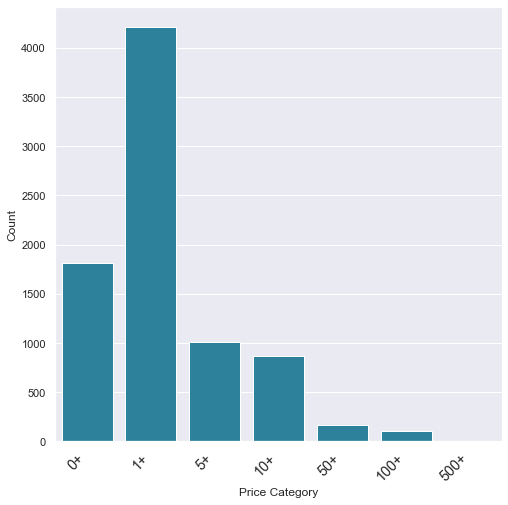

In [29]:
draw_count_plot(df, 'Price Category', 'Price Category', 'Count', fig_size=(8,8), 
               order=price_range_order)

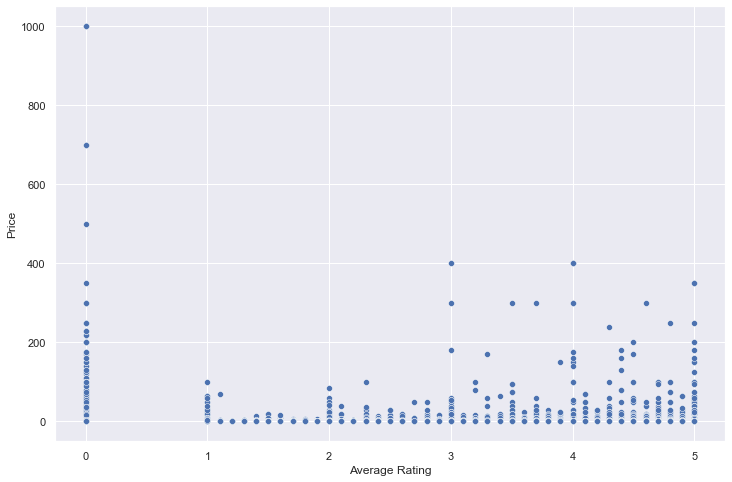

In [30]:
sbn.scatterplot(data=df, y='Price', x='Average Rating')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

In [31]:
df['Price Category'].value_counts()

1+      4207
0+      1816
5+      1010
10+      868
50+      164
100+     103
500+       4
Name: Price Category, dtype: int64

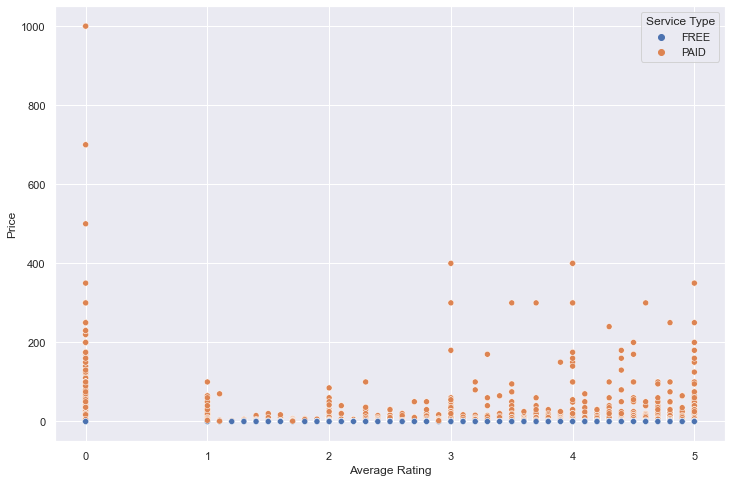

In [32]:
sbn.scatterplot(data=df, y='Price', x='Average Rating', hue='Service Type', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

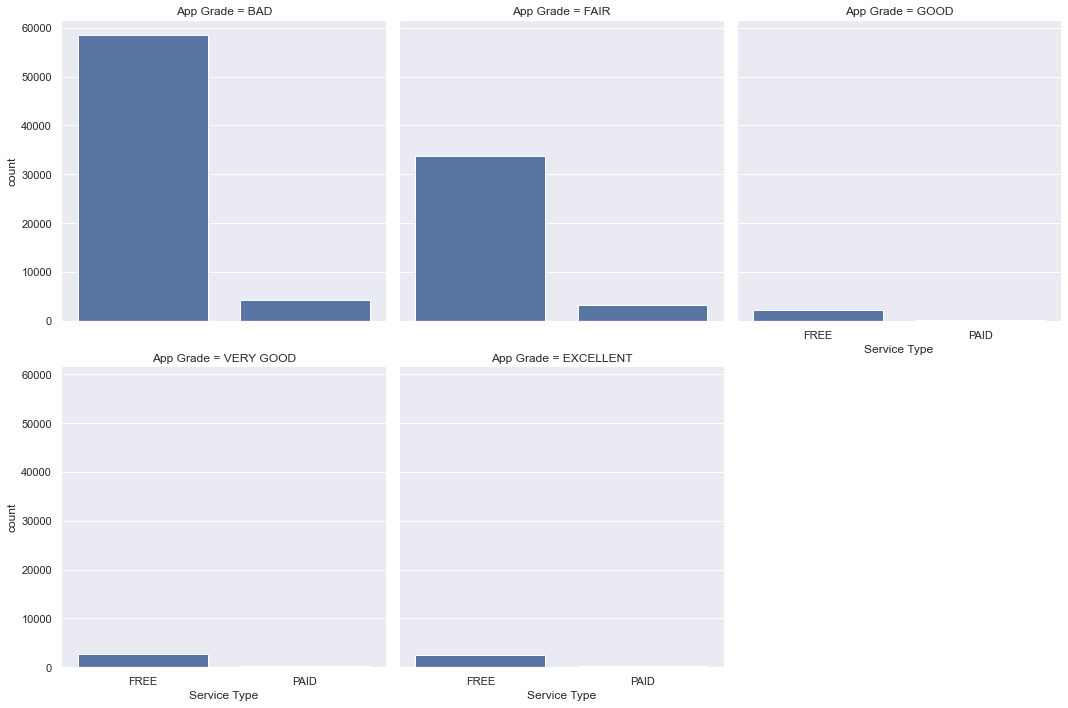

In [33]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=3, height=5, aspect=1.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Service Type", order=['FREE', 'PAID'])

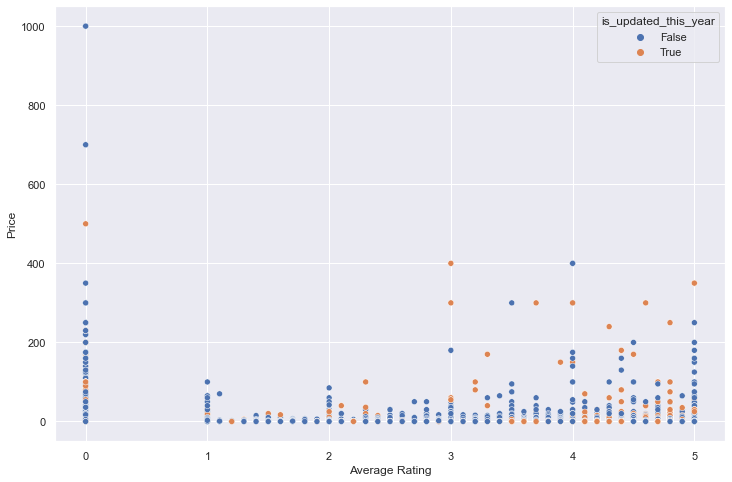

In [34]:
sbn.scatterplot(data=df, x='Average Rating', y='Price', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

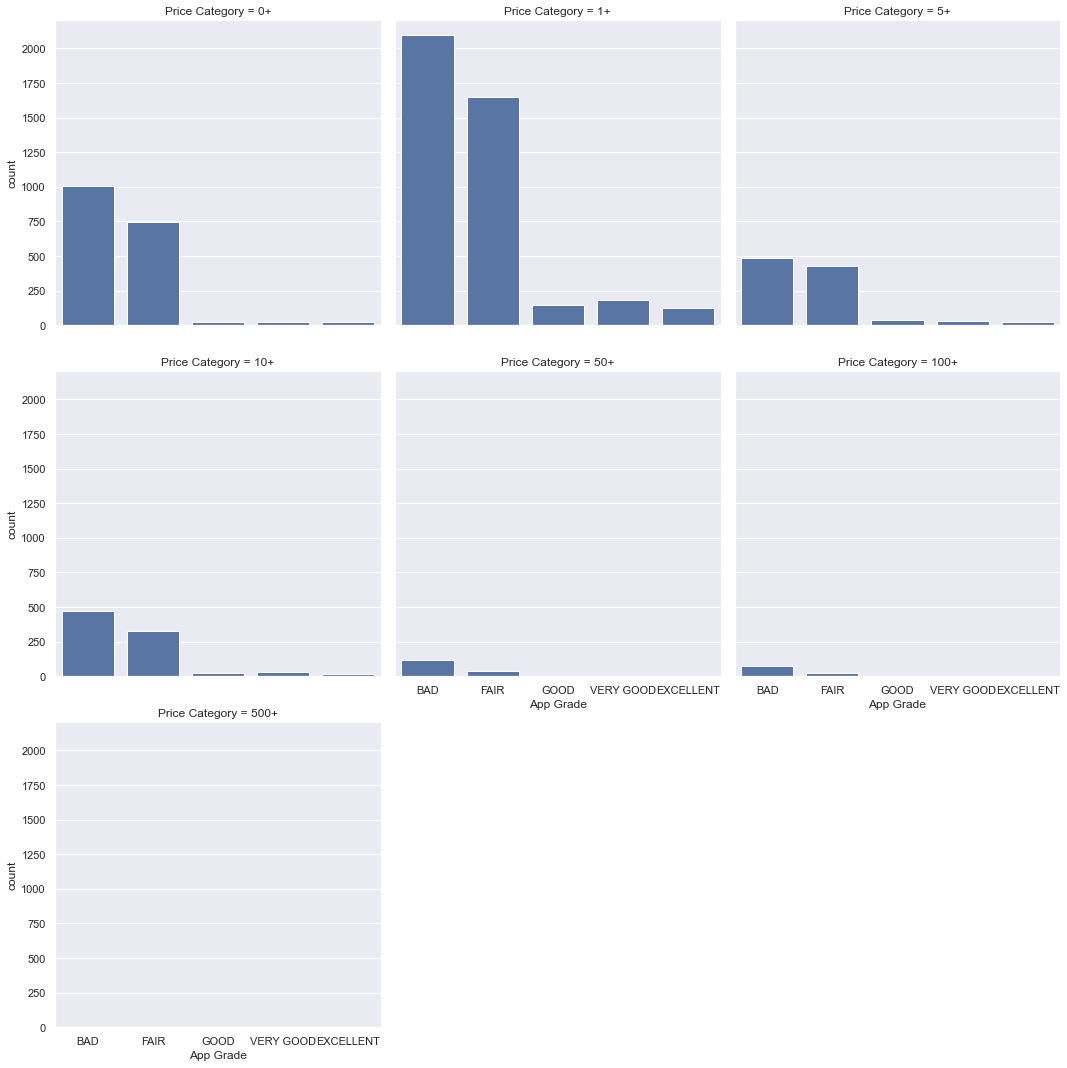

In [35]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Price Category", col_wrap=3, height=5, aspect=1.0,
                                        col_order=price_range_order)
eng_supp_app_grade_plot.map(sbn.countplot, "App Grade", order=app_grade_order)

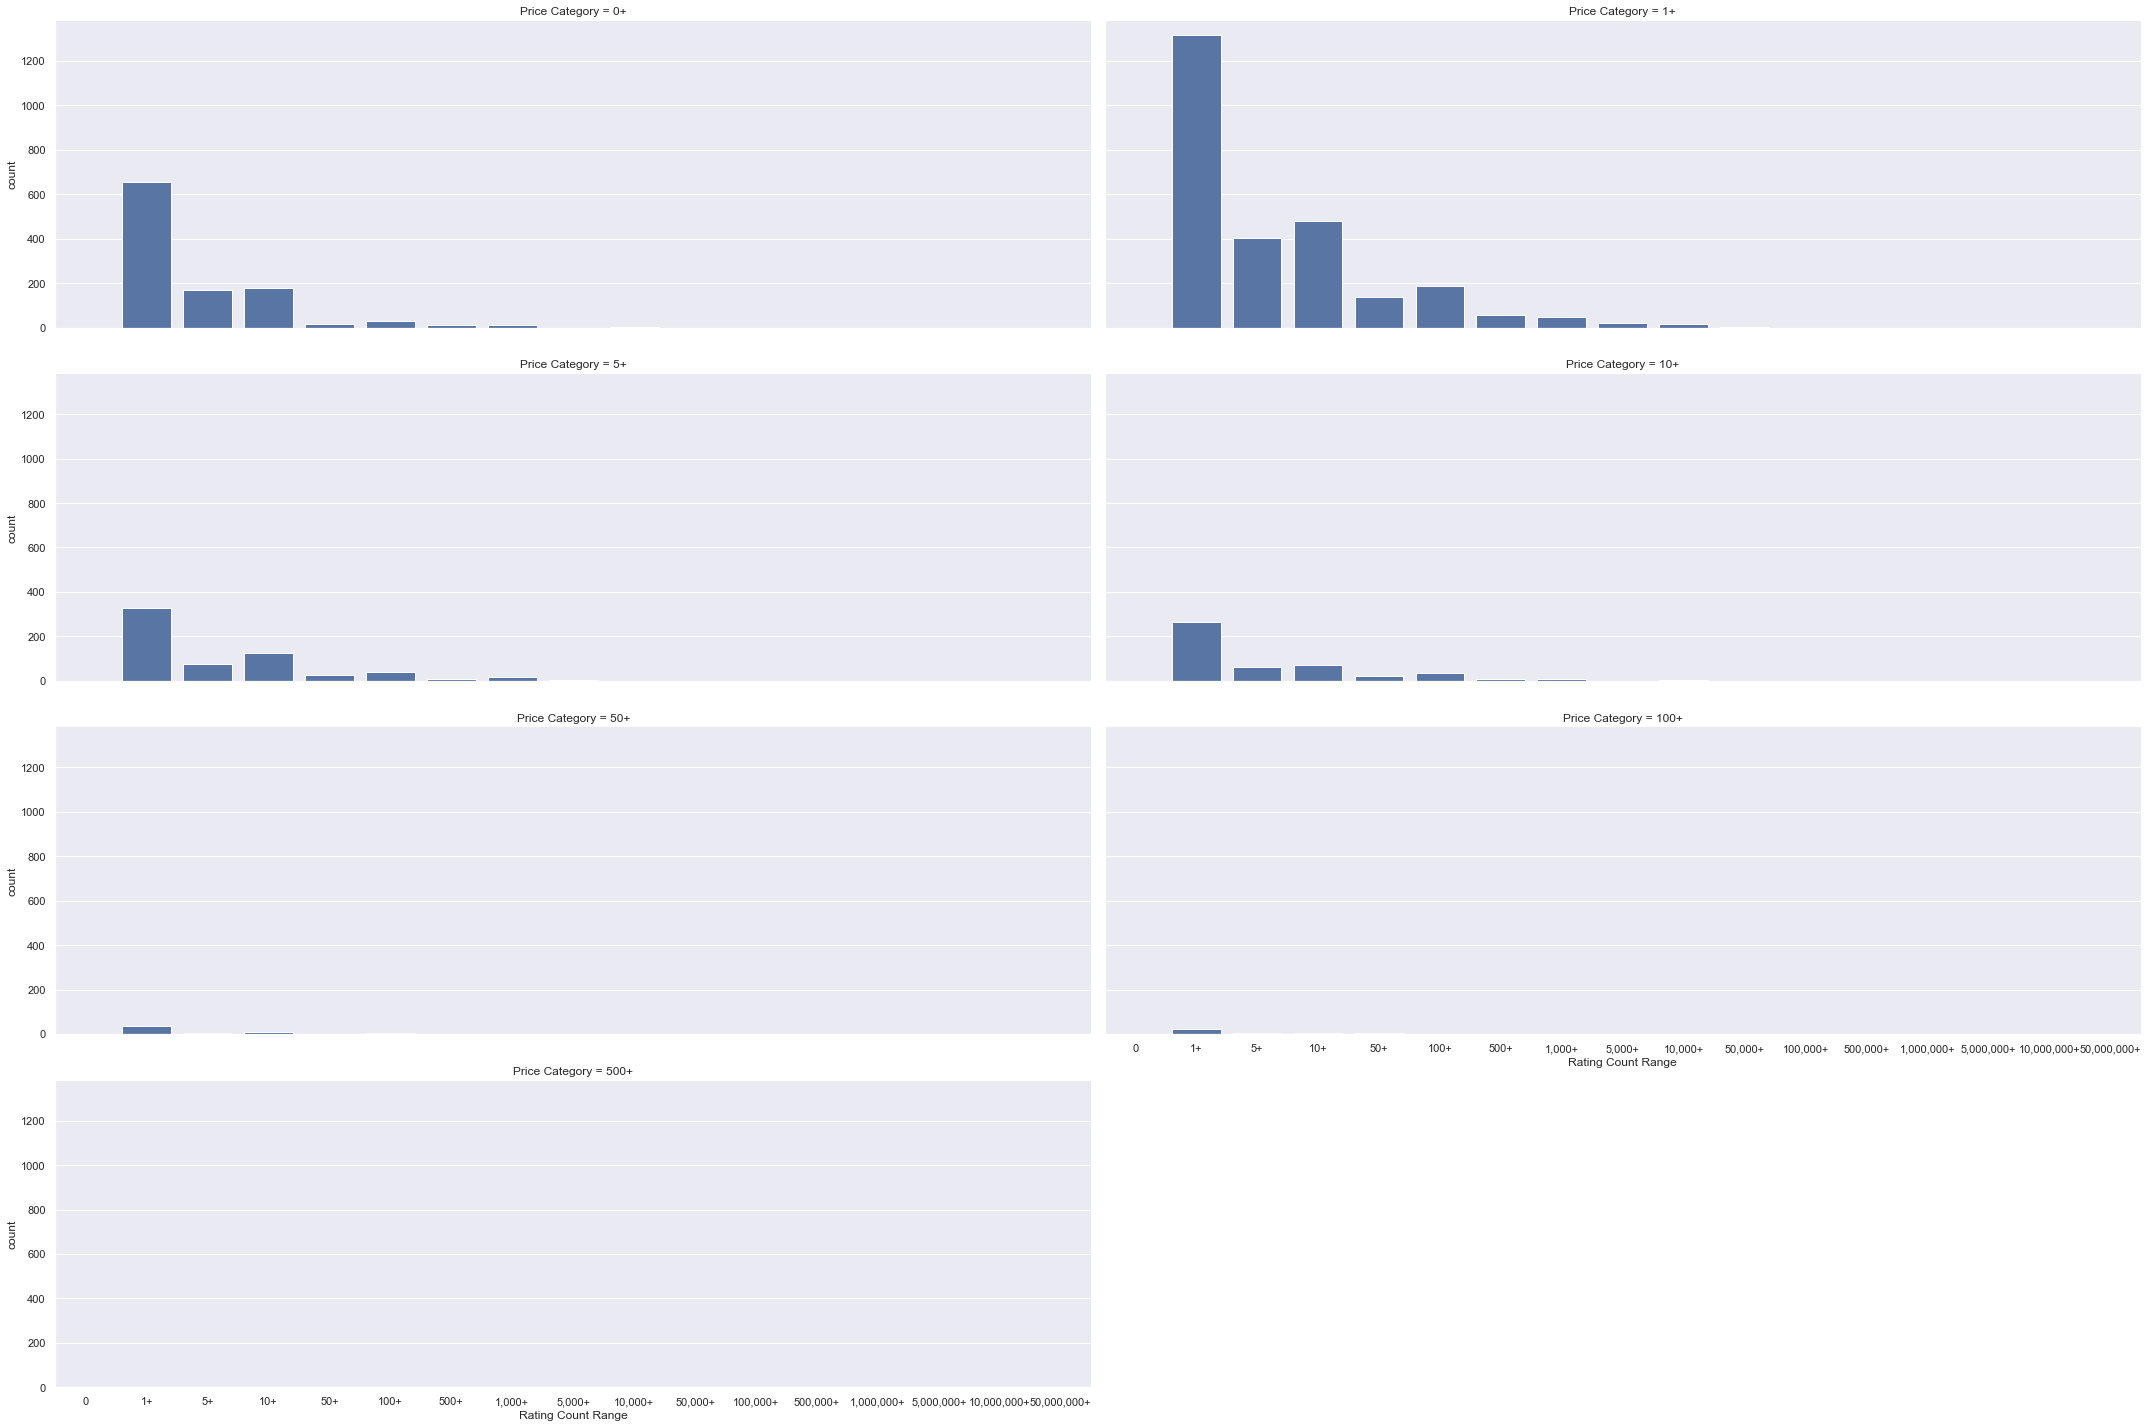

In [36]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Price Category", col_wrap=2, height=5, aspect=3.0,
                                        col_order=price_range_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


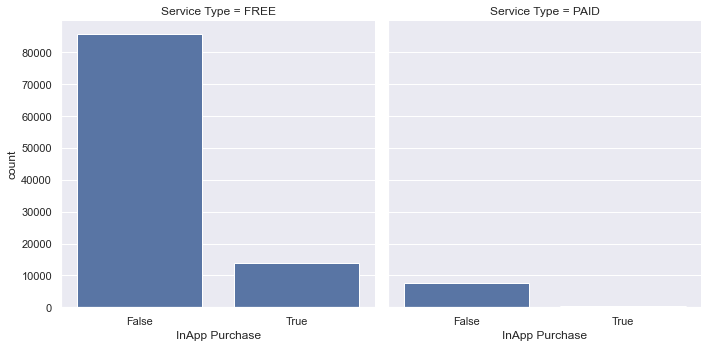

In [37]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Service Type", col_wrap=2, height=5, aspect=1.0)
eng_supp_app_grade_plot.map(sbn.countplot, "InApp Purchase")

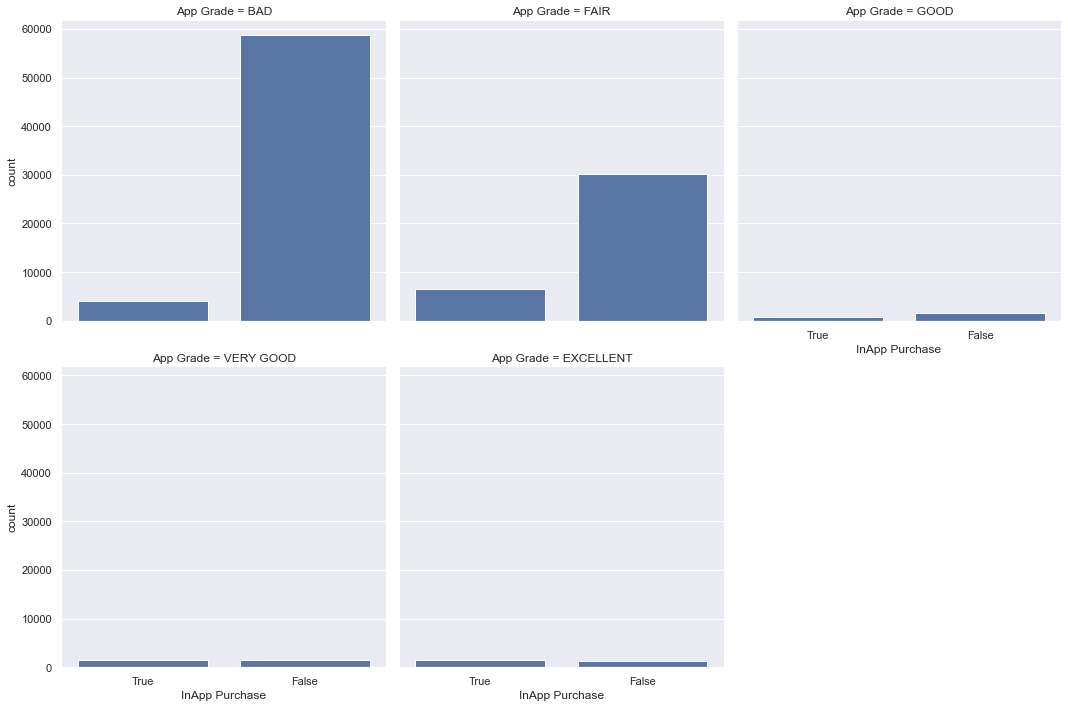

In [38]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=3, height=5, aspect=1.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "InApp Purchase", order=[True, False])

#### Application Rating effect on the app?

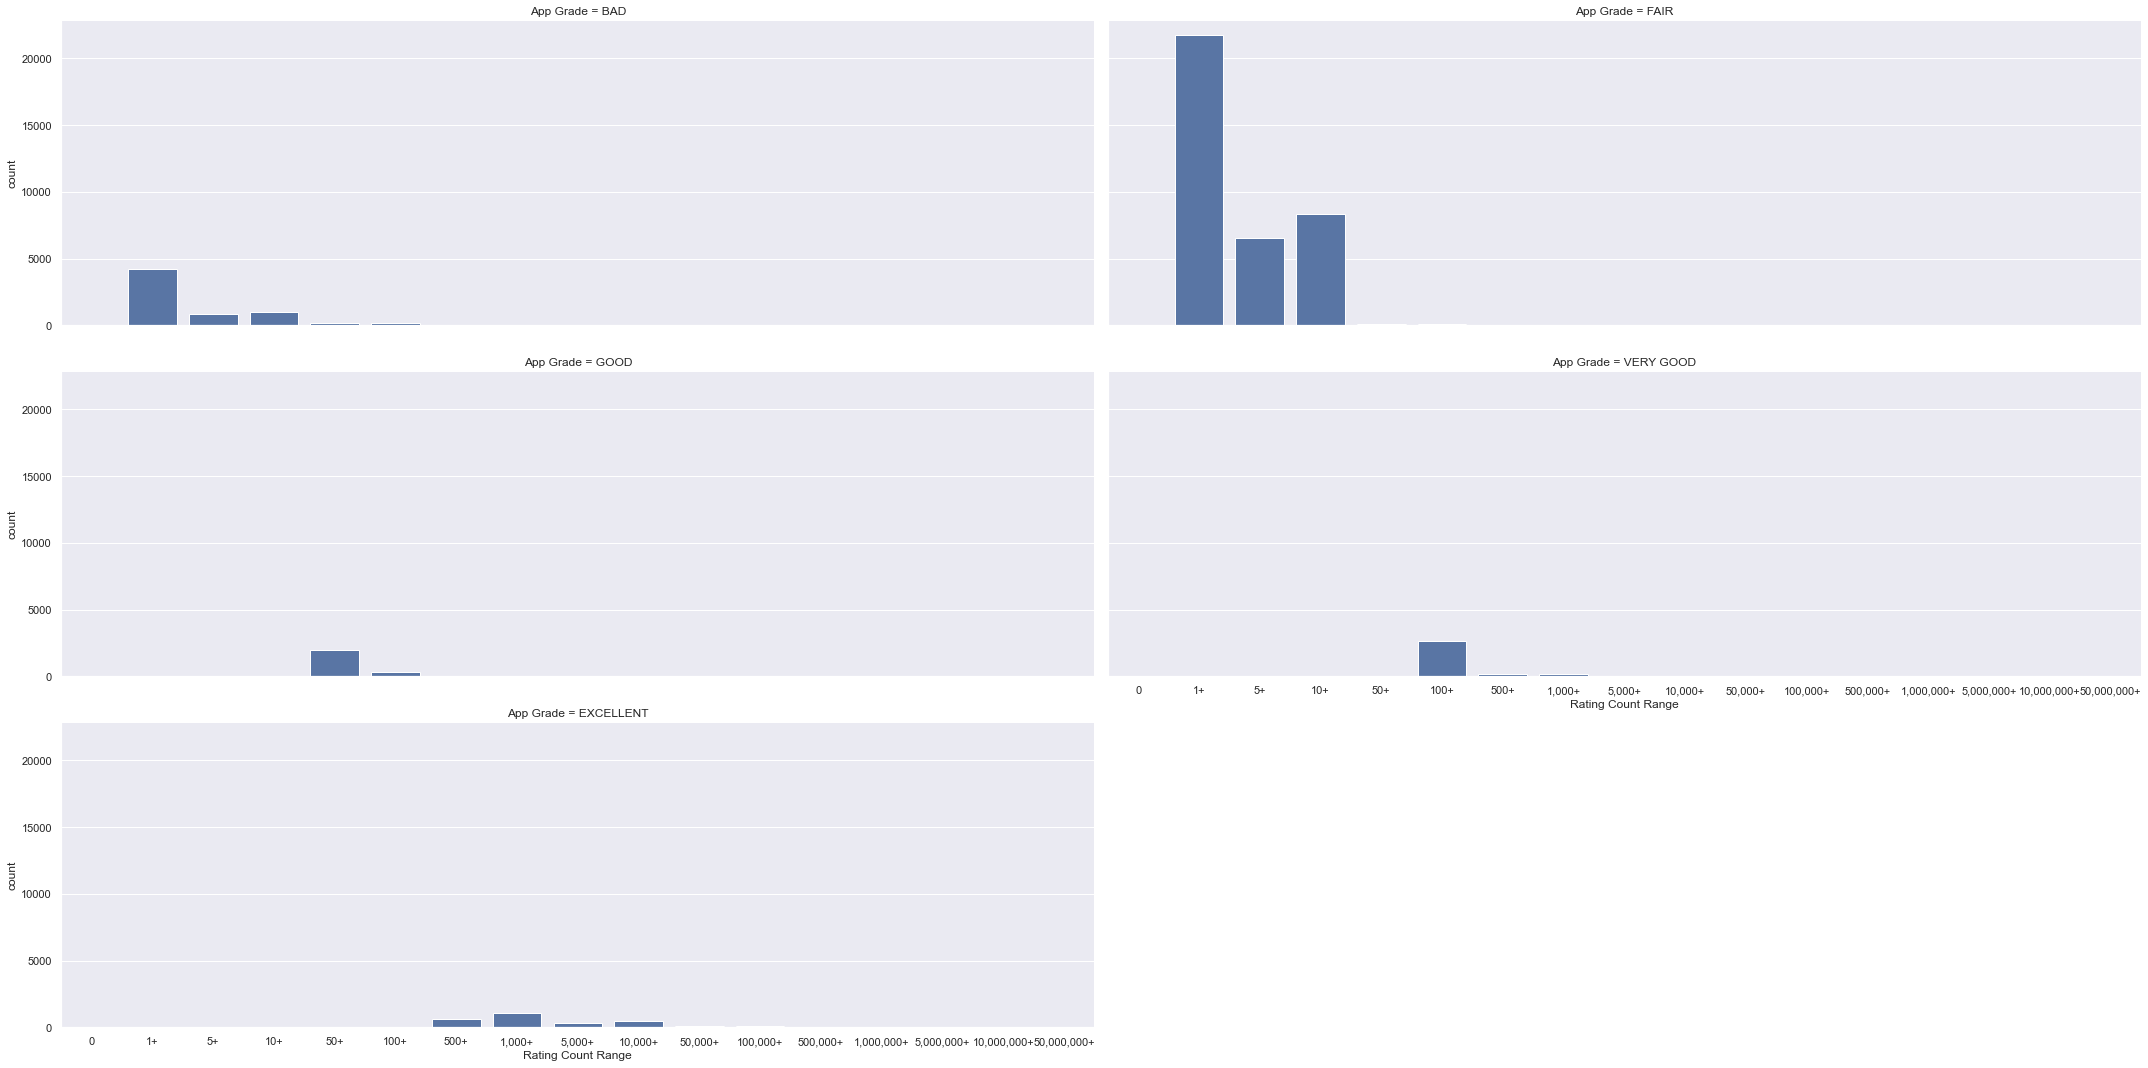

In [39]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=2, height=5, aspect=3.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

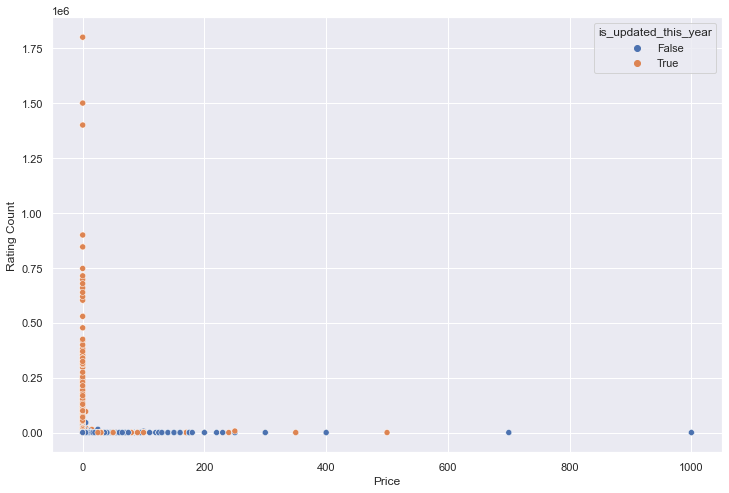

In [40]:
sbn.scatterplot(data=df, y='Rating Count', x='Price', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

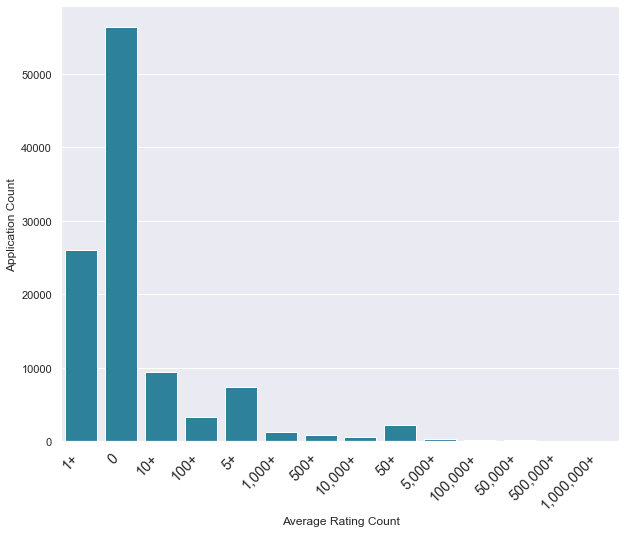

In [41]:
draw_count_plot(df, 'Rating Count Range', 'Average Rating Count', 'Application Count', fig_size=(10,8))

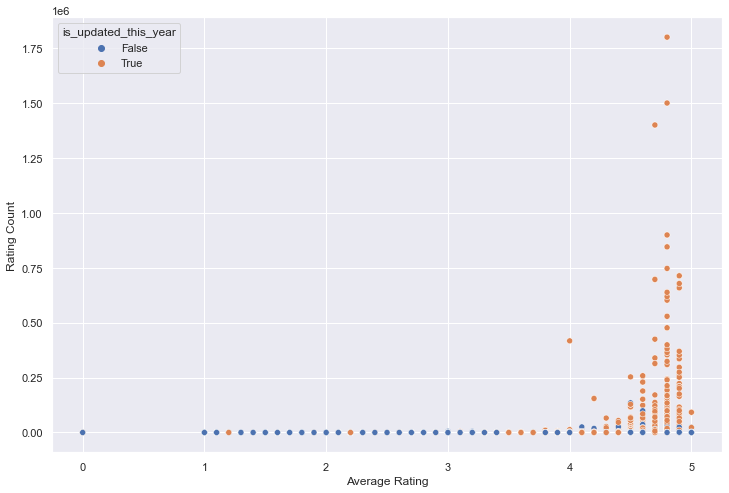

In [42]:
sbn.scatterplot(data=df, y='Rating Count', x='Average Rating', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

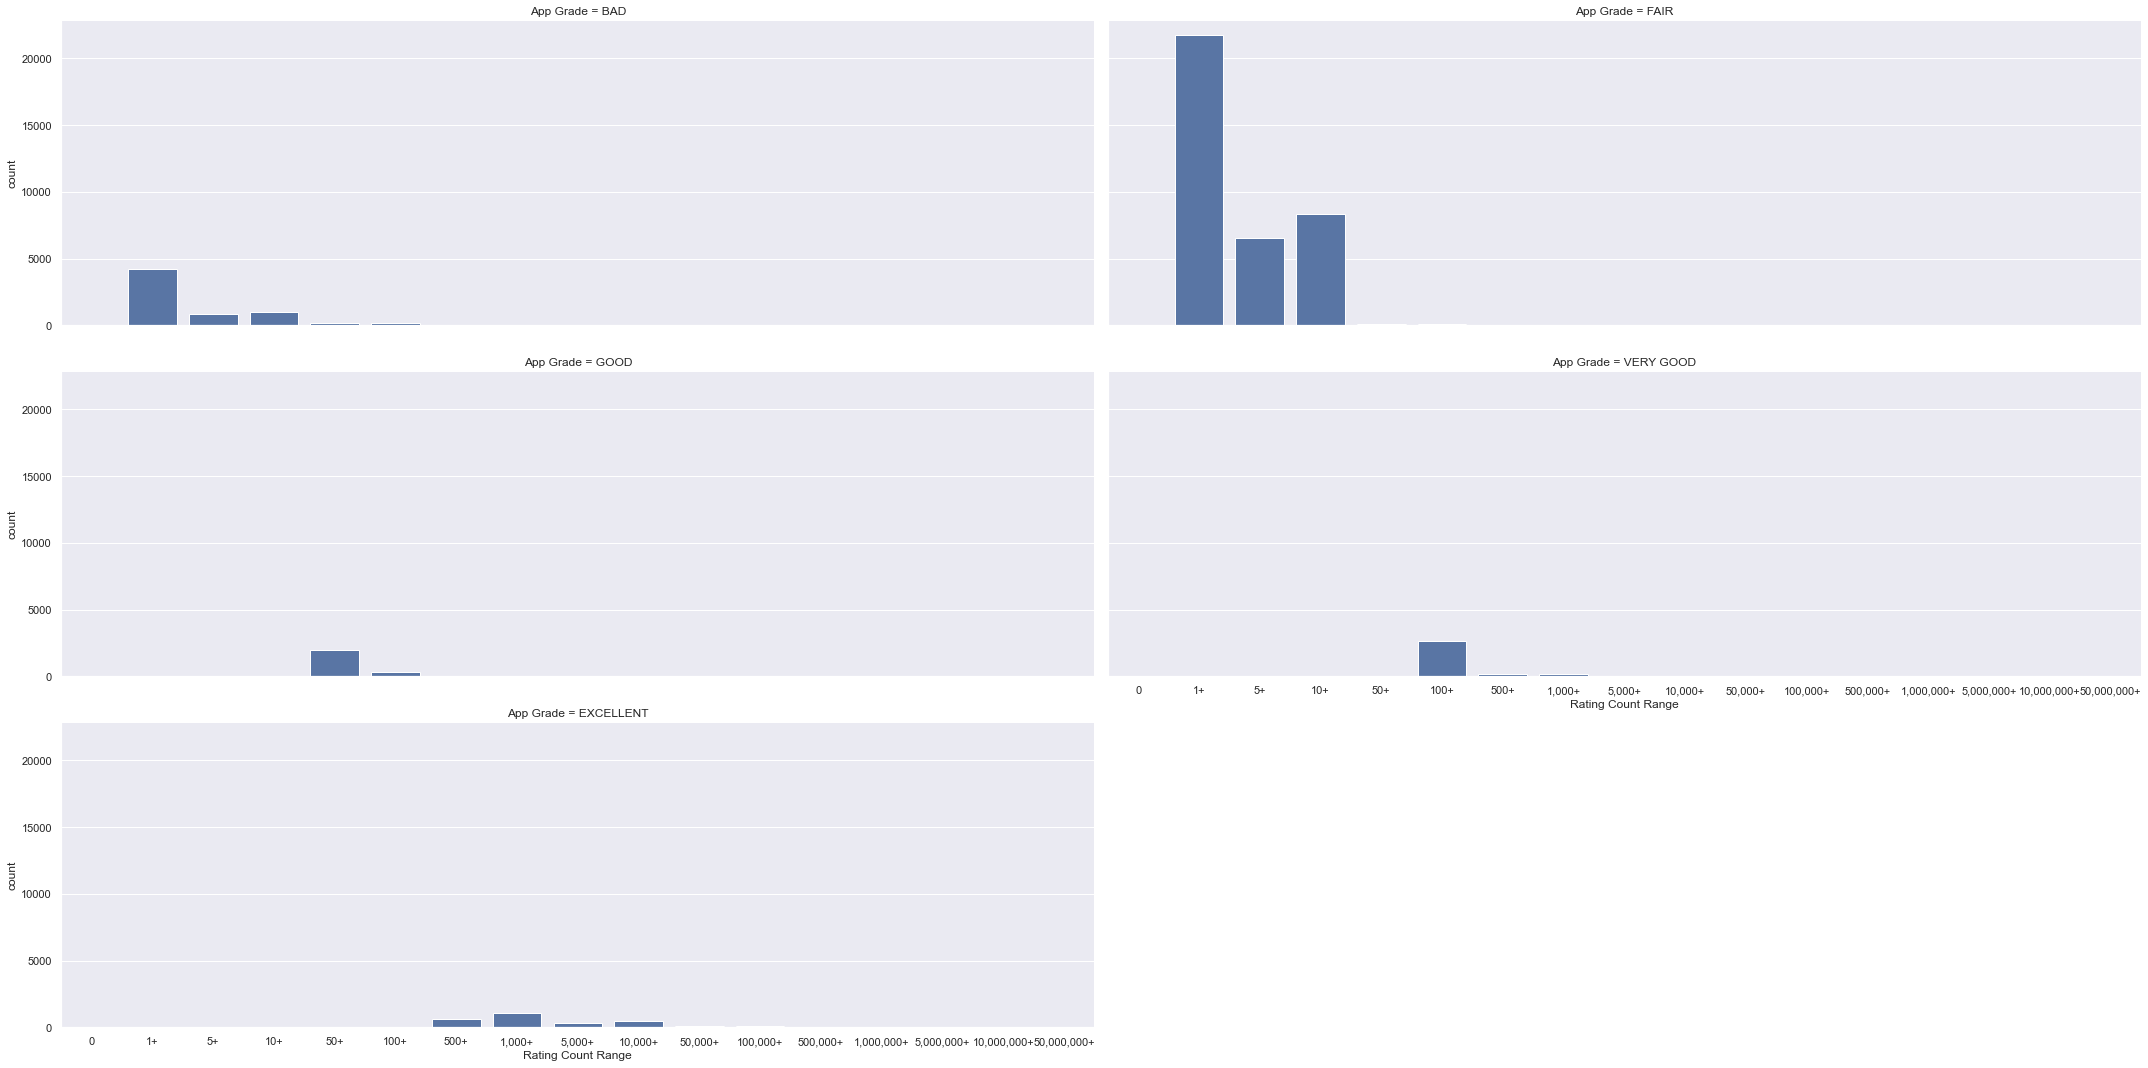

In [43]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=2, height=5, aspect=3.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

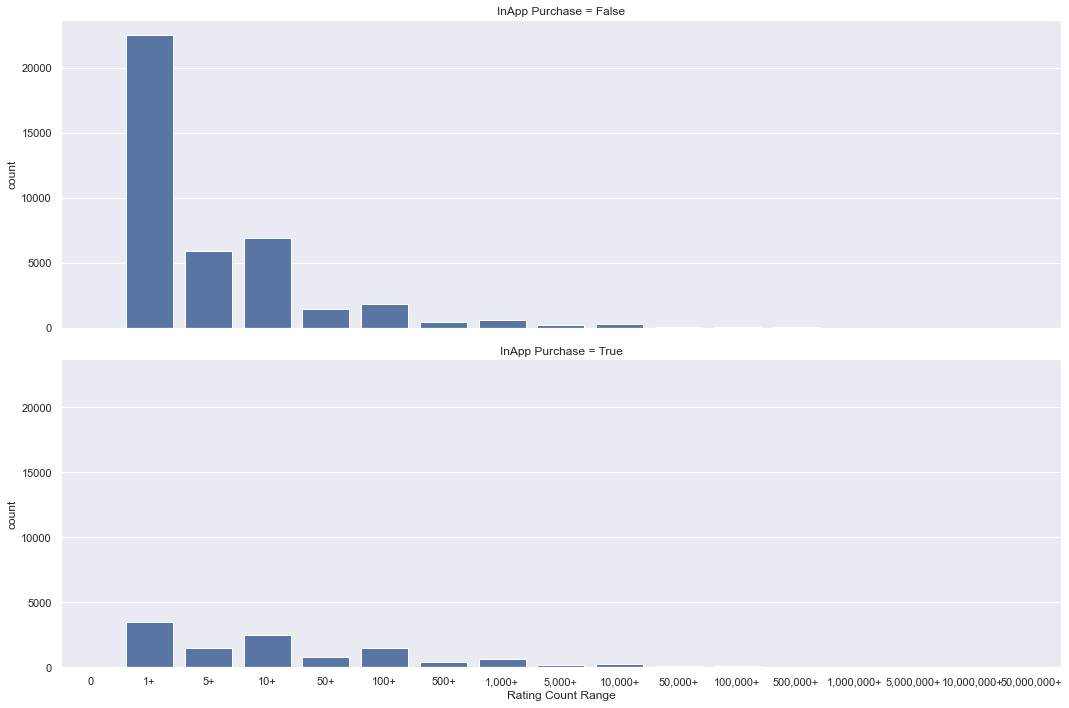

In [44]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="InApp Purchase", col_wrap=1, height=5, aspect=3.0)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

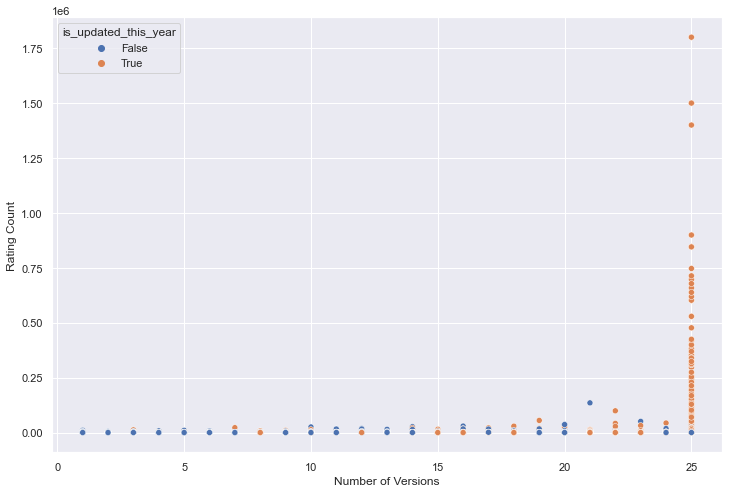

In [45]:
sbn.scatterplot(data=df, y='Rating Count', x='Number of Versions', hue='is_updated_this_year',
                legend='brief', color="#0a4020", palette="deep")
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

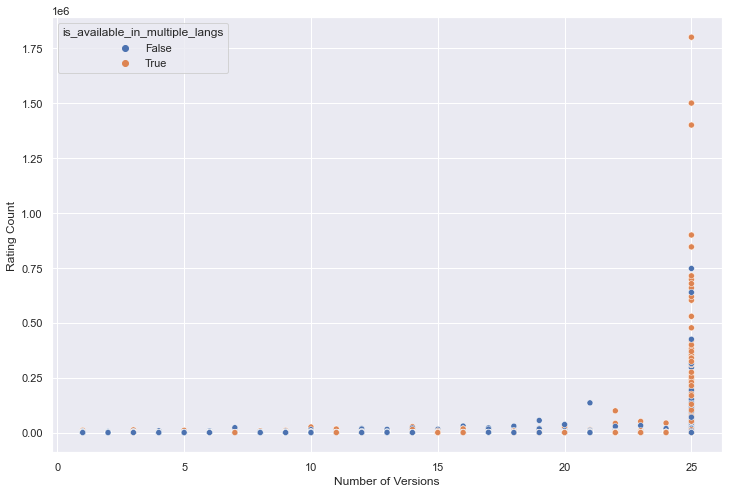

In [46]:
sbn.scatterplot(data=df, y='Rating Count', x='Number of Versions', hue='is_available_in_multiple_langs',
                legend='brief', color="#0a4020", palette="deep")
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

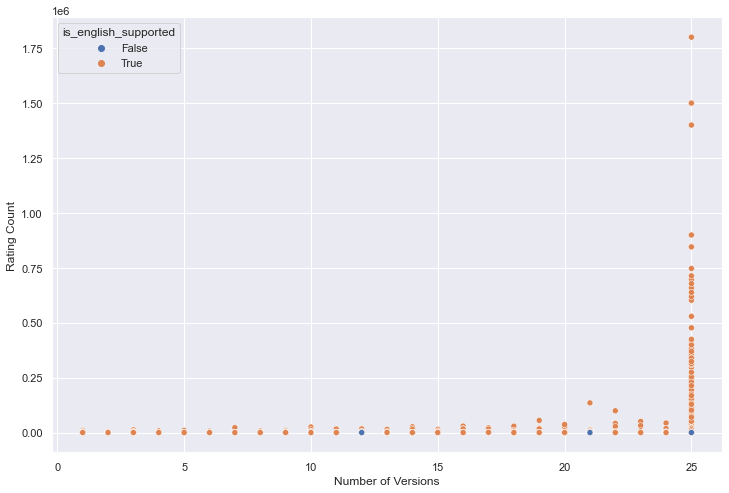

In [47]:
sbn.scatterplot(data=df, y='Rating Count', x='Number of Versions', hue='is_english_supported',
                legend='brief', color="#0a4020", palette="deep")
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

#### Application Type 

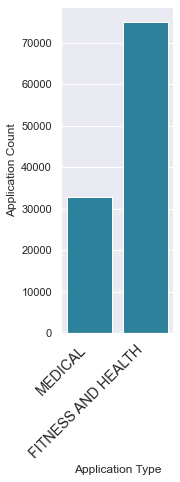

In [48]:
draw_count_plot(df, 'App Type', 'Application Type', 'Application Count', fig_size=(2,6))

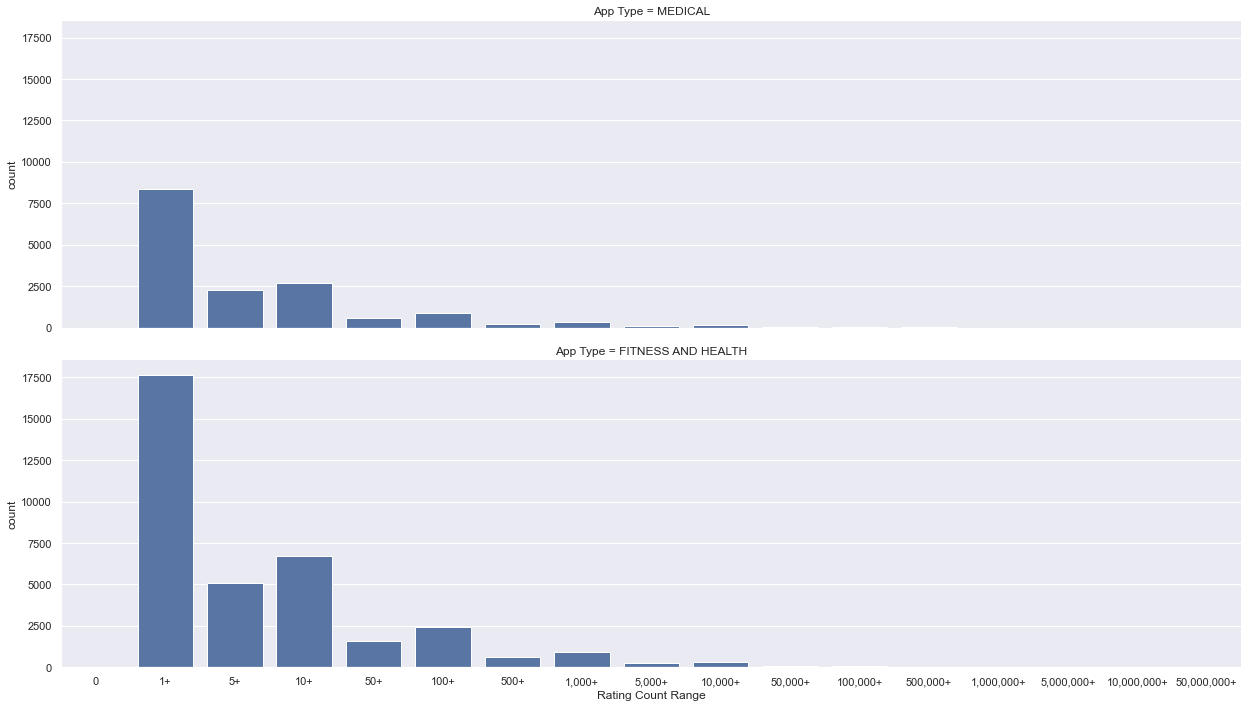

In [49]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Type", col_wrap=1, height=5, aspect=3.5)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

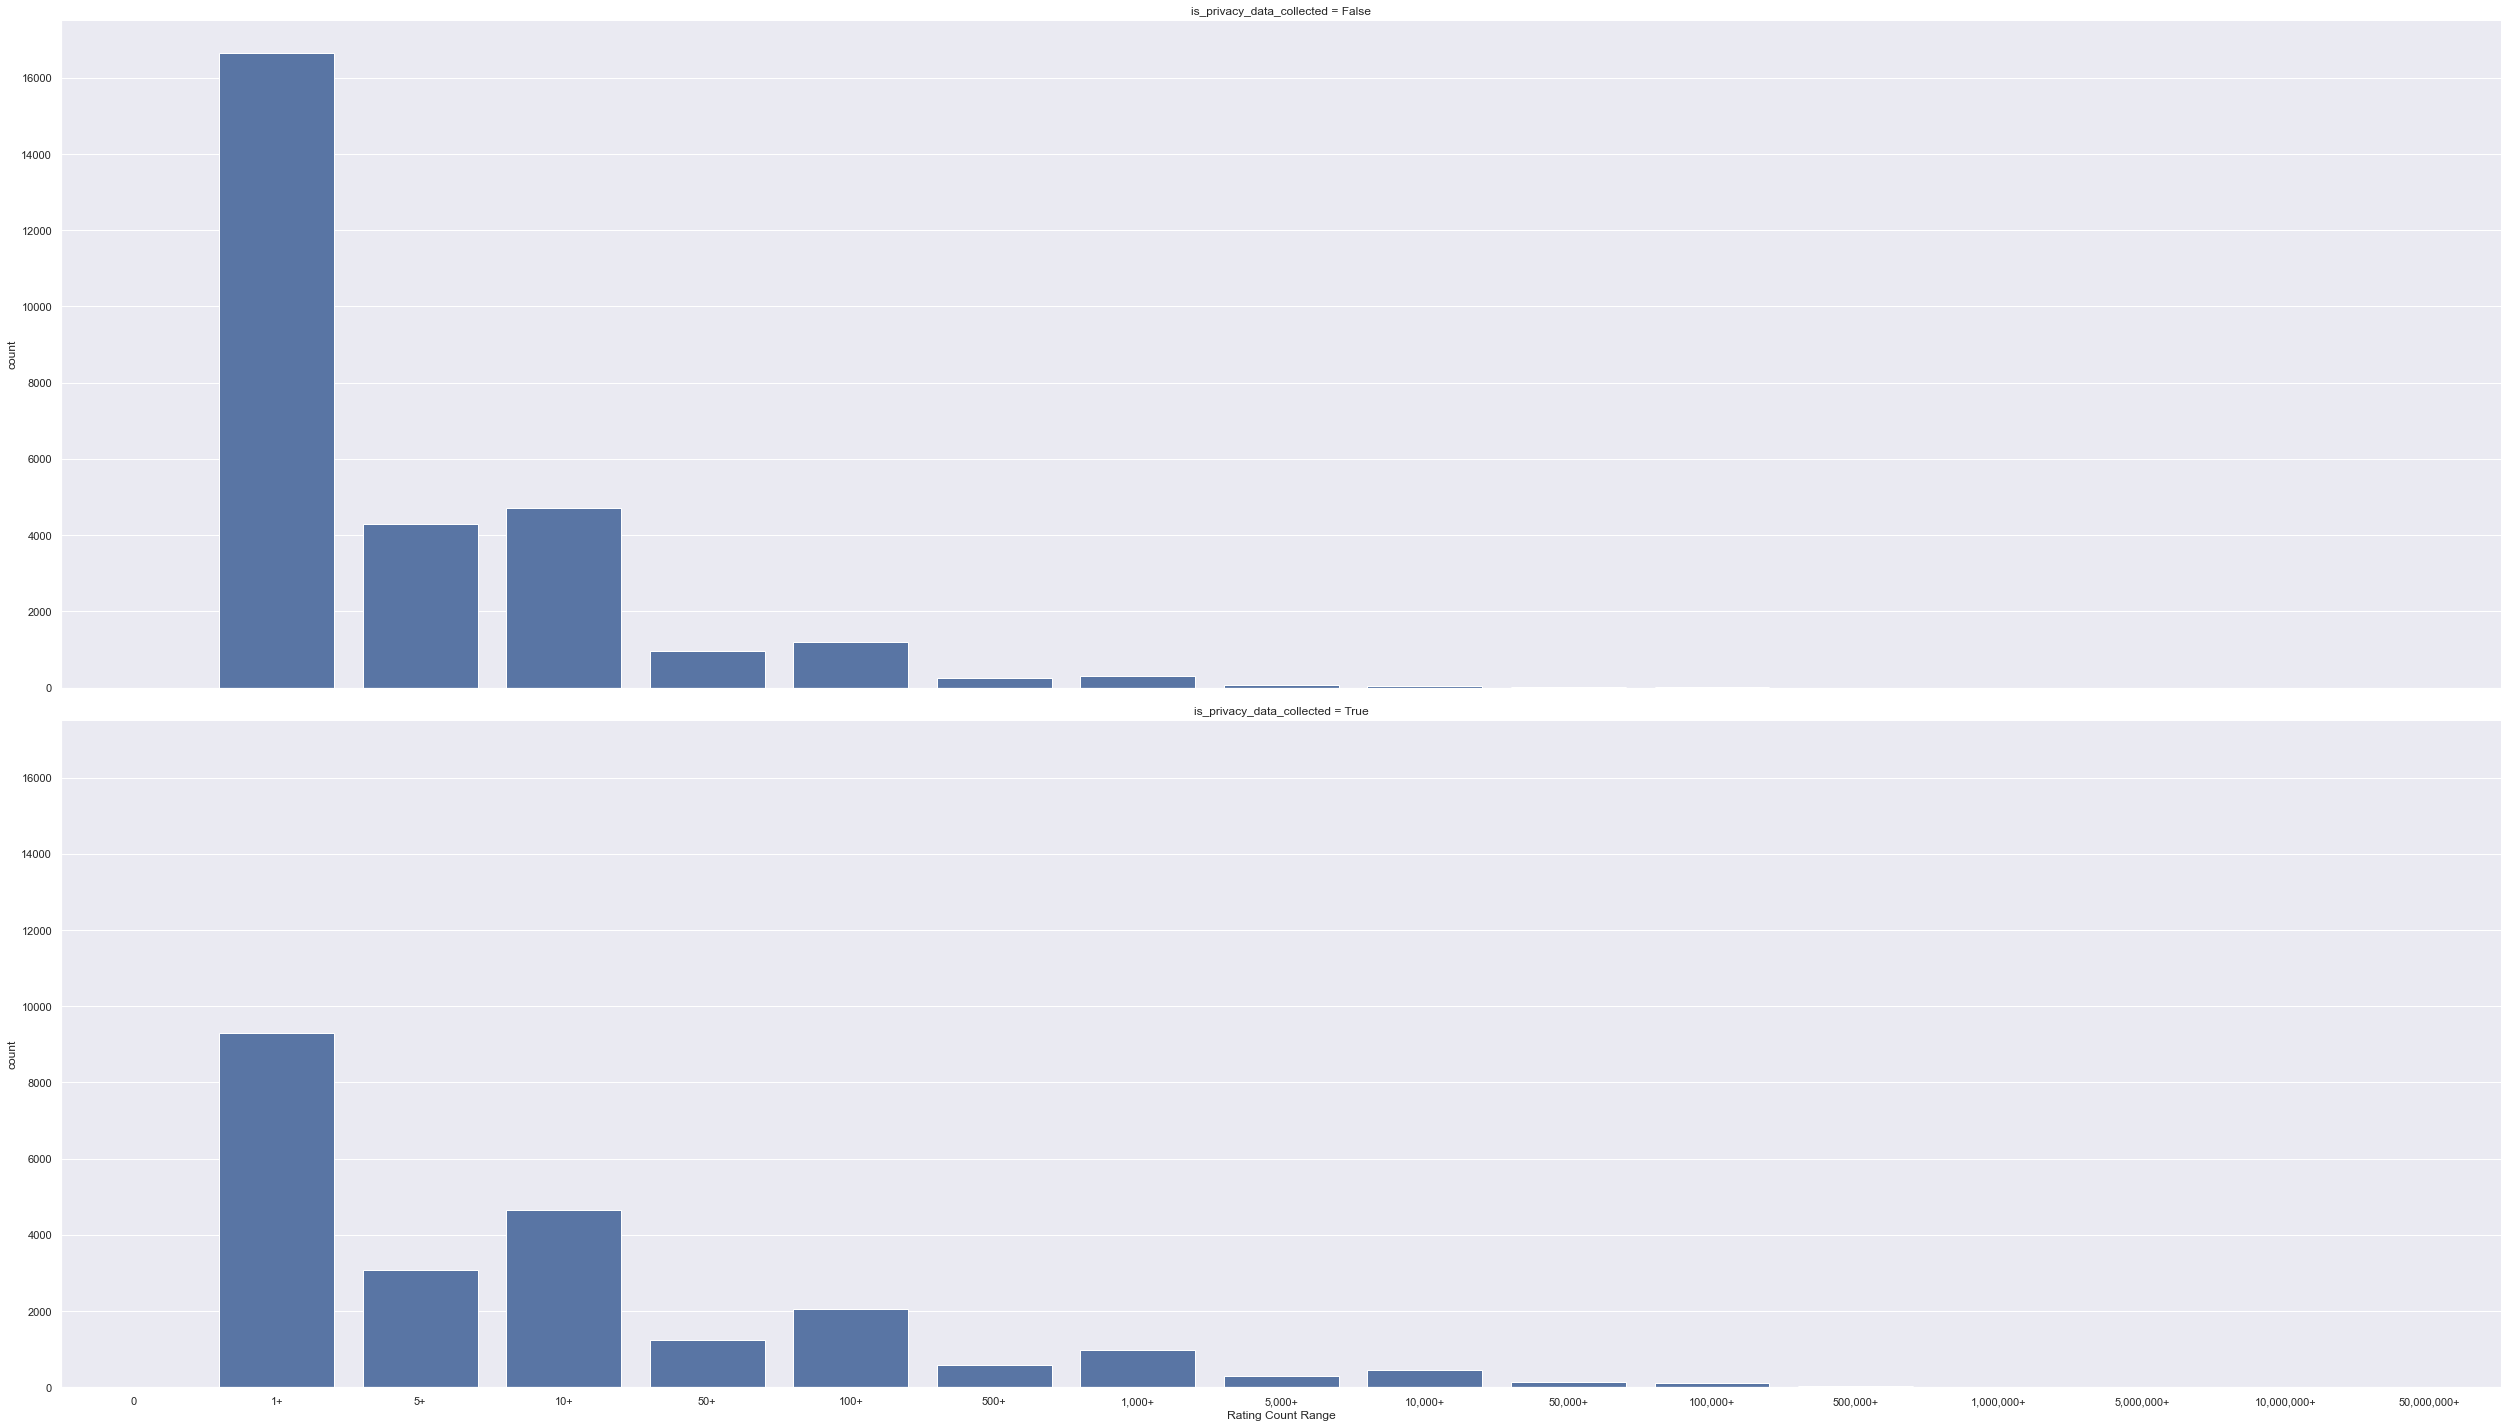

In [50]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="is_privacy_data_collected", col_wrap=1, height=10, aspect=3.5)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

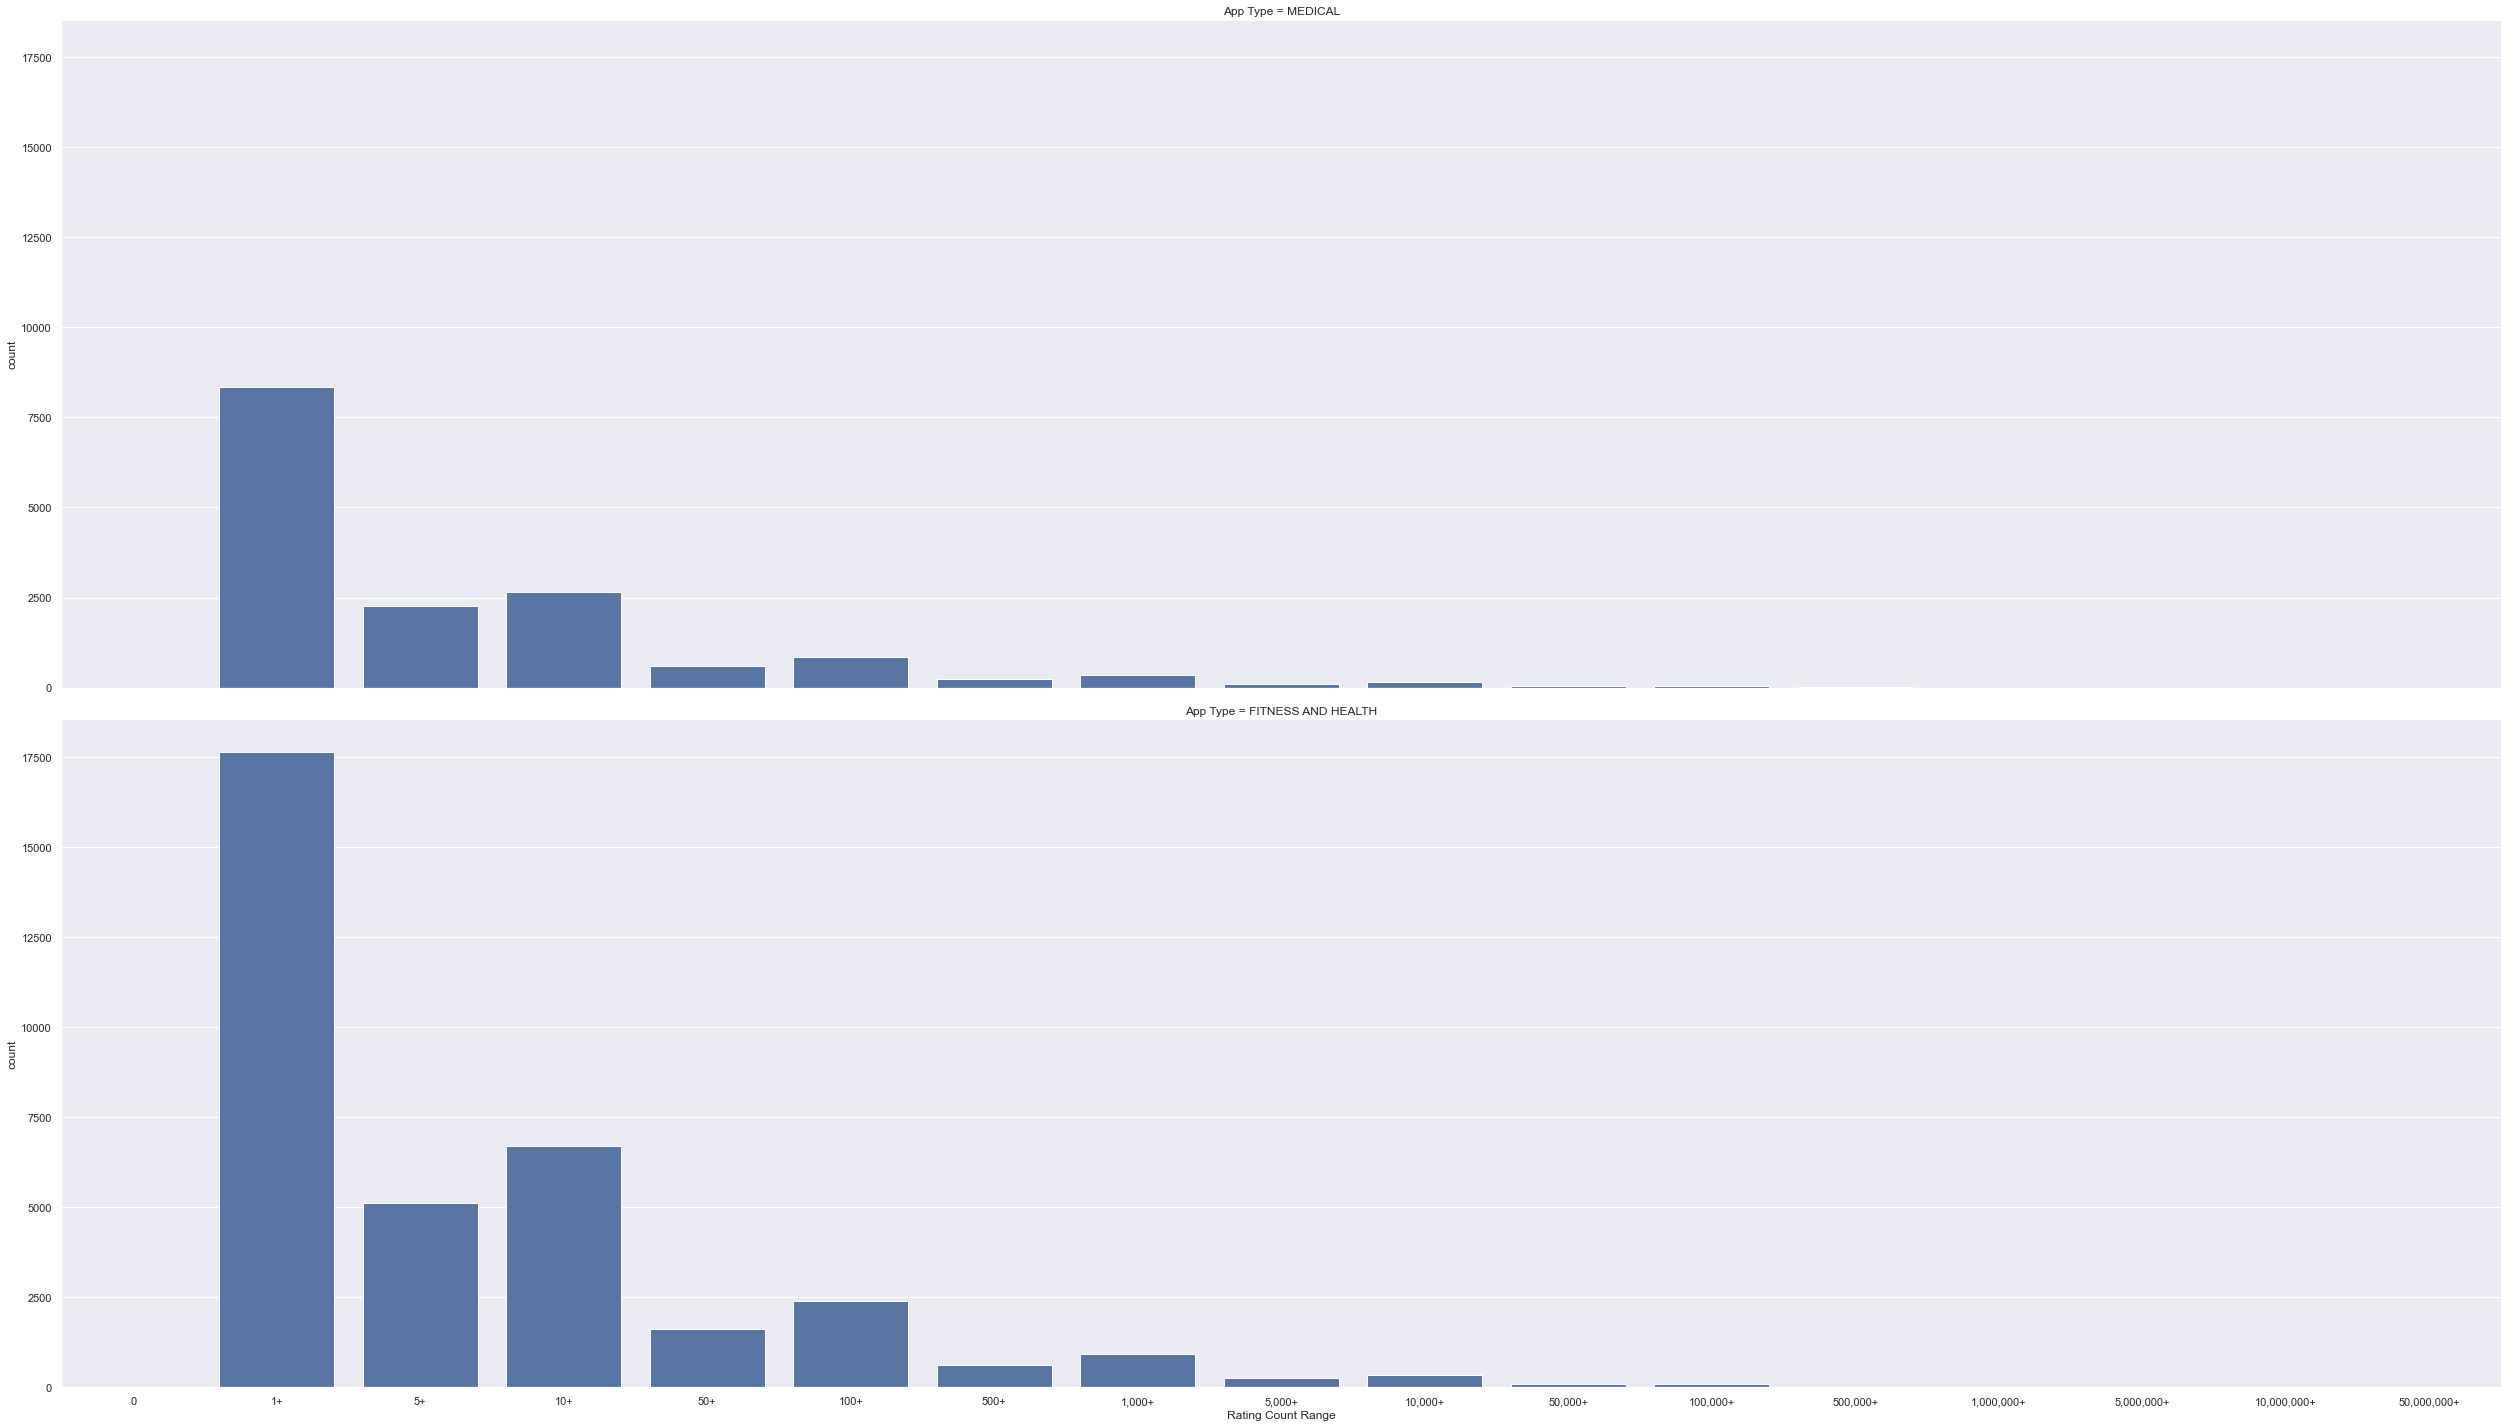

In [51]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Type" ,col_wrap=1, 
                                        height=10, aspect=3.5)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

In [52]:
df['is_privacy_data_collected'].value_counts()

False    63766
True     43996
Name: is_privacy_data_collected, dtype: int64

#### ASSOCIATION RULE MINING

In [53]:
def convert_consequent_to_str(consq):
    return str(consq).replace("frozenset({'", '').replace("})", '').replace("'", '')

In [54]:
def convert_antecedent_to_str(antecedent):
    antecedent = str(antecedent).replace("frozenset({'", '').replace("})", '').replace("'", '')
    return antecedent

In [55]:
def prepare_apriori_columns(df, column_list):
    apriori_df = list()
    for col in column_list:
        apriori_df.append(pd.get_dummies(df[col], prefix=col))
    apriori_df = pd.concat(apriori_df, axis=1)
    return apriori_df

def get_conditions_which_apps_are_most_likely_rated(min_support, min_threshold):
    apriori_df = prepare_apriori_columns(df,['Age Rating', 'InApp Purchase',
                                                       'App Grade', 'is_english_supported', 
                        'Service Type', 'is_available_in_multiple_langs', 'is_privacy_data_collected',
                                             'is_updated_this_year', 'Price Category'] )
    rules = apriori(apriori_df, min_support=min_support, use_colnames=True)
    association_rules_df = association_rules(rules, metric='confidence', min_threshold=min_threshold)
    association_rules_df["antecedent_len"] = association_rules_df["antecedents"].apply(lambda x: len(x))
    association_rules_df["consequents_len"] = association_rules_df["consequents"].apply(lambda x: len(x))
    association_rules_df['antecedents'] = association_rules_df['antecedents'].apply(convert_antecedent_to_str)
    association_rules_df['consequents'] = association_rules_df['consequents'].apply(convert_consequent_to_str)
    association_rules_df.sort_values(by=['confidence'], ascending=False, inplace=True)
    return association_rules_df[(association_rules_df['consequents_len']==1) & 
                                (association_rules_df['antecedent_len']>1)]

In [56]:
association_df = get_conditions_which_apps_are_most_likely_rated(0.5, 0.5)

In [57]:
def print_consequents_and_antecedents(df, consequent):
    filtered_df = df[df['consequents'].str.find(consequent) > -1]
    i = 1
    for index in filtered_df.index:
        if (i < 10):
            ants = filtered_df.at[index, 'antecedents']
            cons = filtered_df.at[index, 'consequents']
            support = filtered_df.at[index, 'support']
            conviction = filtered_df.at[index, 'conviction']
            confidence = filtered_df.at[index, 'confidence']
            print(f'{i}. {ants} => {cons} ({round(support,2), round(confidence,2), round(conviction,2)})')
            i = i + 1

In [58]:
print_consequents_and_antecedents(association_df,'Service Type')

1. InApp Purchase_False, App Grade_BAD => Service Type_FREE ((0.51, 0.93, 1.09))
2. is_english_supported_True, Age Rating_4+ => Service Type_FREE ((0.51, 0.92, 0.95))
3. is_english_supported_True, InApp Purchase_False => Service Type_FREE ((0.74, 0.92, 0.9))
4. is_english_supported_True, is_available_in_multiple_langs_False => Service Type_FREE ((0.57, 0.91, 0.88))
5. InApp Purchase_False, is_available_in_multiple_langs_False => Service Type_FREE ((0.54, 0.91, 0.84))
6. is_english_supported_True, is_updated_this_year_False => Service Type_FREE ((0.61, 0.91, 0.8))
7. InApp Purchase_False, is_updated_this_year_False => Service Type_FREE ((0.57, 0.9, 0.77))
8. is_english_supported_True, InApp Purchase_False, is_updated_this_year_False => Service Type_FREE ((0.53, 0.9, 0.75))


In [59]:
print_consequents_and_antecedents(association_df,'App Grade')

1. InApp Purchase_False, Service Type_FREE => App Grade_BAD ((0.51, 0.64, 1.15))


In [60]:
print_consequents_and_antecedents(association_df,'Age Rating')

1. is_english_supported_True, Service Type_FREE => Age Rating_4+ ((0.51, 0.6, 1.01))


In [61]:
print_consequents_and_antecedents(association_df,'is_updated_this_year')

1. is_english_supported_True, InApp Purchase_False => is_updated_this_year_False ((0.59, 0.73, 1.07))
2. Service Type_FREE, is_english_supported_True, InApp Purchase_False => is_updated_this_year_False ((0.53, 0.72, 1.02))
3. InApp Purchase_False, Service Type_FREE => is_updated_this_year_False ((0.57, 0.71, 1.01))
4. is_english_supported_True, Service Type_FREE => is_updated_this_year_False ((0.61, 0.7, 0.97))


In [62]:
print_consequents_and_antecedents(association_df,'is_available_in_multiple_langs')

1. InApp Purchase_False, Service Type_FREE => is_available_in_multiple_langs_False ((0.54, 0.68, 0.98))
2. is_english_supported_True, InApp Purchase_False => is_available_in_multiple_langs_False ((0.54, 0.67, 0.94))
3. is_english_supported_True, Service Type_FREE => is_available_in_multiple_langs_False ((0.57, 0.66, 0.92))


In [63]:
print_consequents_and_antecedents(association_df,'is_english_supported')

1. Service Type_FREE, Age Rating_4+ => is_english_supported_True ((0.51, 0.94, 1.07))
2. Service Type_FREE, is_updated_this_year_False => is_english_supported_True ((0.61, 0.94, 1.04))
3. InApp Purchase_False, is_updated_this_year_False => is_english_supported_True ((0.59, 0.94, 1.03))
4. Service Type_FREE, InApp Purchase_False, is_updated_this_year_False => is_english_supported_True ((0.53, 0.93, 0.99))
5. Service Type_FREE, InApp Purchase_False => is_english_supported_True ((0.74, 0.93, 0.92))
6. Service Type_FREE, is_available_in_multiple_langs_False => is_english_supported_True ((0.57, 0.9, 0.68))
7. InApp Purchase_False, is_available_in_multiple_langs_False => is_english_supported_True ((0.54, 0.9, 0.67))


In [64]:
print_consequents_and_antecedents(association_df,'Price Category')

#### CLUSTERING

In [65]:
df[:5]

,Unnamed: 0,App Name,Size,Age Rating,Languages,Price,InApp Purchase,Average Rating,Rating Count,Privacy Data,App Link,Number of Versions,Last Version Date,First Version Date,App Type,is_english_supported,Service Type,Rating Count Range,is_available_in_multiple_langs,is_privacy_data_collected,is_app_ever_updated,Price Category,is_updated_this_year,App Grade
0,0,H and W Drug Store,21.5 MB,12+,"English, Spanish",0.00,False,4.0,4,NaN,https://apps.apple.com/us/app/h-and-w-drug-sto...,1,NaN,NaN,MEDICAL,True,FREE,1+,True,False,False,None,False,FAIR
1,1,H&P-card™,10.1 MB,17+,"English, Spanish",2.99,False,1.0,1,NaN,https://apps.apple.com/us/app/h-p-card/id56971...,5,"Sep 28, 2020","Oct 20, 2012",MEDICAL,True,PAID,1+,True,False,True,1+,False,BAD
2,2,H-Book – osobní zdravotní záznamy,47.1 MB,12+,"English, Czech",0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-book-osobn%C3%...,21,"Jun 28, 2017","Jun 5, 2013",MEDICAL,True,FREE,0,True,False,True,None,False,BAD
3,3,H-FACT,4.1 MB,12+,English,0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-fact/id1568969345,5,"Nov 24, 2021","Jul 5, 2021",MEDICAL,True,FREE,0,False,False,True,None,False,BAD
4,4,H-Module,27.6 MB,17+,Not Specified,0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-module/id15728...,2,"Jun 26, 2021","Jun 22, 2021",MEDICAL,False,FREE,0,False,False,True,None,False,BAD


- Price
- Average Rating
- Rating count
- Number of versions
- 

In [66]:
def get_age_integer(age_rating):
    return int(age_rating.replace('+',''))

In [67]:
df['age_rating_integer'] = df['Age Rating'].apply(get_age_integer)

In [68]:
def draw_elbow_graph(kmeans_df):
    wcss=[]
    for i in range(1,15):
        kmeans = KMeans(i)
        kmeans.fit(kmeans_df)
        wcss_iter = kmeans.inertia_
        wcss.append(wcss_iter)

    number_clusters = range(1,15)
    pyplot.subplot(2, 2, 1)
    pyplot.plot(number_clusters,wcss)
    pyplot.title('The Elbow title')
    pyplot.xlabel('Number of clusters')
    pyplot.ylabel('WCSS')
    fig = pyplot.gcf()
    fig.set_size_inches(24, 16)

In [69]:
def execute_kmeans(df, columns,n_cluster):
    standard_scaler = StandardScaler()
    kmeans_df = df[columns]
    kmeans_df_scaled = standard_scaler.fit_transform(kmeans_df)
    draw_elbow_graph(kmeans_df_scaled)
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(kmeans_df_scaled)
    labels = kmeans.predict(kmeans_df_scaled)
    centroids = kmeans.cluster_centers_
    kmeans_df_cluster = kmeans_df.copy()
    kmeans_df_cluster['cluster'] = labels
#     print(kmeans_df_cluster['cluster'].value_counts())
    if (len(columns) == 3):
        ax = pyplot.subplot(2, 2, 2, projection='3d')
        ax.scatter(kmeans_df_scaled[:,0], kmeans_df_scaled[:,1], kmeans_df_scaled[:,2] ,c=kmeans.labels_, 
                   cmap='rainbow',
               edgecolor='k', s=40, alpha = 0.5)
        ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
               kmeans.cluster_centers_[:,2], s = 300, c = 'r',
               marker='*', label = 'Centroid')
    elif (len(columns) == 4):
        ax = pyplot.subplot(2, 2, 2, projection='3d')
        ax.scatter(kmeans_df_scaled[:,0], kmeans_df_scaled[:,1], kmeans_df_scaled[:,2] , kmeans_df_scaled[:,3]
                   ,c=kmeans.labels_, 
                   cmap='rainbow',
               edgecolor='k', s=40, alpha = 0.5)
        ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
               kmeans.cluster_centers_[:,2], kmeans.cluster_centers_[:,3], s = 300, c = 'r',
               marker='*', label = 'Centroid')
    else:
        ax = pyplot.subplot(2, 2, 2)
        ax.scatter(kmeans_df_scaled[:, 0],kmeans_df_scaled[:, 1],
            c=kmeans.labels_,cmap='rainbow')
    
    fig = pyplot.gcf()
    fig.set_size_inches(20, 16)
    return kmeans_df_cluster

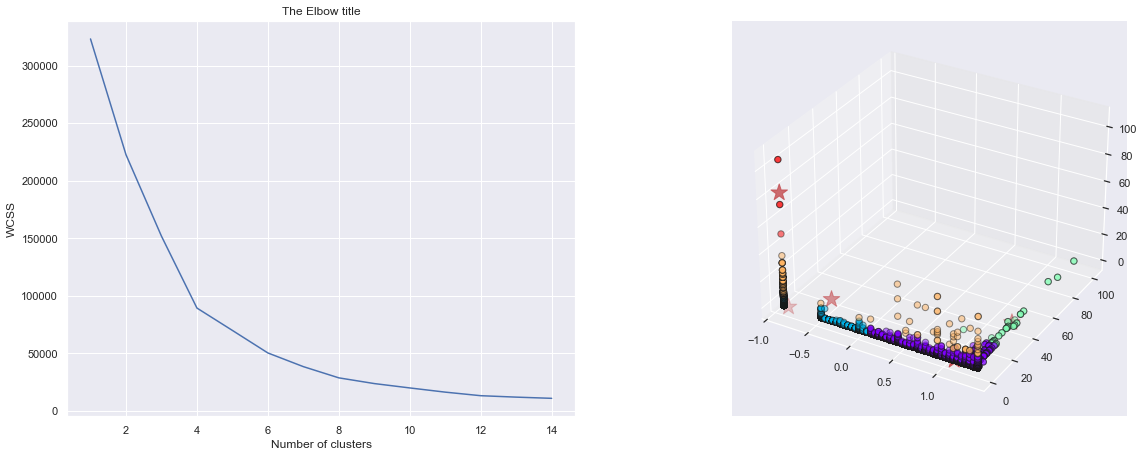

In [70]:
kmeans_df_cluster_df3 = execute_kmeans(df, ['Average Rating', 'Rating Count', 'Price'], 5)

In [71]:
kmeans_df_cluster_df3['cluster'].value_counts()

1    61803
0    45724
3      185
2       45
4        5
Name: cluster, dtype: int64

In [72]:
kmeans_df_cluster_df3.groupby(by='cluster').min()

,Average Rating,Rating Count,Price
cluster,,,
0,2.3,1,0.00
1,0.0,0,0.00
2,4.0,352200,0.00
3,0.0,0,79.99
4,0.0,0,499.99


In [73]:
kmeans_df_cluster_df3.groupby(by='cluster').max()

,Average Rating,Rating Count,Price
cluster,,,
0,5.0,339400,74.99
1,2.2,3200,74.99
2,4.9,1800000,0.00
3,5.0,6900,399.99
4,0.0,0,999.99


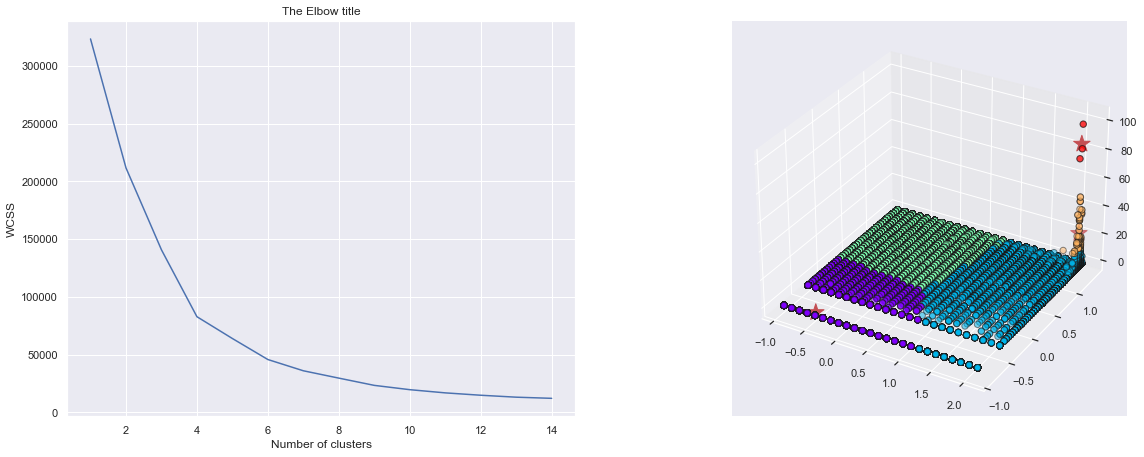

In [74]:
kmeans_df_cluster_df4 = execute_kmeans(df, ['Number of Versions', 'Average Rating', 'Rating Count'], 5)

In [75]:
kmeans_df_cluster_df4['cluster'].value_counts()

0    56285
2    31163
1    20238
3       70
4        6
Name: cluster, dtype: int64

In [76]:
kmeans_df_cluster_df4.groupby(by='cluster').min()

,Number of Versions,Average Rating,Rating Count
cluster,,,
0,1,0.0,0
1,13,0.0,0
2,1,2.2,1
3,25,4.0,222800
4,25,4.7,1400000


In [77]:
kmeans_df_cluster_df4.groupby(by='cluster').max()

,Number of Versions,Average Rating,Rating Count
cluster,,,
0,17,2.3,1500
1,25,5.0,213300
2,15,5.0,26700
3,25,4.9,899500
4,25,4.8,1800000


#### CLASSIFICATION MODEL

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107762 entries, 0 to 107761
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      107762 non-null  int64  
 1   App Name                        107762 non-null  object 
 2   Size                            107762 non-null  object 
 3   Age Rating                      107762 non-null  object 
 4   Languages                       107762 non-null  object 
 5   Price                           107762 non-null  float64
 6   InApp Purchase                  107762 non-null  bool   
 7   Average Rating                  107762 non-null  float64
 8   Rating Count                    107762 non-null  int64  
 9   Privacy Data                    43996 non-null   object 
 10  App Link                        107762 non-null  object 
 11  Number of Versions              107762 non-null  int64  
 12  Last Version Dat

In [79]:
def draw_heatmap():
    df_num = df[['Price', 'Rating Count', 'Number of Versions', 'Average Rating']]
    ax = sbn.heatmap( df_num.corr(method='spearman'), cmap = 'rainbow', annot=True)
    fig = pyplot.gcf()
    fig.set_size_inches(8, 6)

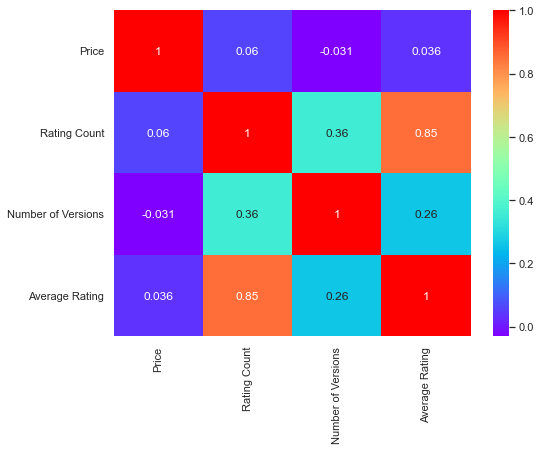

In [80]:
draw_heatmap()

##### Rating count is a good variable to determine the average rating based on correlation

In [81]:
df[:5]

,Unnamed: 0,App Name,Size,Age Rating,Languages,Price,InApp Purchase,Average Rating,Rating Count,Privacy Data,App Link,Number of Versions,Last Version Date,First Version Date,App Type,is_english_supported,Service Type,Rating Count Range,is_available_in_multiple_langs,is_privacy_data_collected,is_app_ever_updated,Price Category,is_updated_this_year,App Grade,age_rating_integer
0,0,H and W Drug Store,21.5 MB,12+,"English, Spanish",0.00,False,4.0,4,NaN,https://apps.apple.com/us/app/h-and-w-drug-sto...,1,NaN,NaN,MEDICAL,True,FREE,1+,True,False,False,None,False,FAIR,12
1,1,H&P-card™,10.1 MB,17+,"English, Spanish",2.99,False,1.0,1,NaN,https://apps.apple.com/us/app/h-p-card/id56971...,5,"Sep 28, 2020","Oct 20, 2012",MEDICAL,True,PAID,1+,True,False,True,1+,False,BAD,17
2,2,H-Book – osobní zdravotní záznamy,47.1 MB,12+,"English, Czech",0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-book-osobn%C3%...,21,"Jun 28, 2017","Jun 5, 2013",MEDICAL,True,FREE,0,True,False,True,None,False,BAD,12
3,3,H-FACT,4.1 MB,12+,English,0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-fact/id1568969345,5,"Nov 24, 2021","Jul 5, 2021",MEDICAL,True,FREE,0,False,False,True,None,False,BAD,12
4,4,H-Module,27.6 MB,17+,Not Specified,0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-module/id15728...,2,"Jun 26, 2021","Jun 22, 2021",MEDICAL,False,FREE,0,False,False,True,None,False,BAD,17


In [82]:
target_attributes = ['Price Category Ord', 'Rating Count Range Ord', 'Number of Versions', 'Age Rating Ord', 'InApp Purchase Ord',
                    'is_english_supported Ord', 'is_available_in_multiple_langs Ord', 'Service Type Ord',
                     'App Type Ord', 'is_privacy_data_collected Ord', 'is_app_ever_updated Ord',
                     'is_updated_this_year Ord' ]

In [83]:
df['Price Category'].isna().any()

True

In [84]:
(df['Price Category'].unique())

array([None, '1+', '100+', '5+', '0+', '10+', '50+', '500+'], dtype=object)

In [85]:
def create_ordinal_fields(df):
    age_rating_map = {'4+' : 3, '9+' : 2, '12+' : 1, '17+' : 0 }
    app_grading_map = {'EXCELLENT' : 4, 'VERY GOOD' : 3, 'GOOD' : 2, 'FAIR' : 1, 'BAD' : 0 }
    rating_count_map = {'0' : 0, '1+' : 1, '5+' : 2, '10+' : 3, '50+' : 4, '100+' : 5, '500+' : 6, '1,000+' : 7,
                       '5,000+' : 8, '10,000+' : 9, '50,000+' : 10, '100,000+' : 11, '500,000+' : 12, '1,000,000+': 13}
    price_map = {np.nan : 0, 'None' : 0, '0+' : 1, '1+' : 1, '5+' : 2, '10+' : 3, '50+' : 4, '100+' : 5, '500+' : 6}
    inapp_purchase_map = {True : 1, False : 0}
    service_type_map = {'PAID' : 1, 'FREE' : 0}
    app_type_map = {'MEDICAL' : 1, 'FITNESS AND HEALTH' : 0}
    english_supported_map = {True : 1, False : 0}
    available_in_multiple_langs_map = {True : 1, False : 0}
    privacy_data_collected_map = {True : 1, False : 0}
    app_ever_updated_map = {True : 1, False : 0}
    updated_this_year_map = {True : 1, False : 0}
    df['Age Rating Ord'] = df['Age Rating'].replace(age_rating_map)
    df['InApp Purchase Ord'] = df['InApp Purchase'].replace(inapp_purchase_map)
    df['is_english_supported Ord'] = df['is_english_supported'].replace(english_supported_map)
    df['is_available_in_multiple_langs Ord'] = df['is_available_in_multiple_langs'].replace(available_in_multiple_langs_map)
    df['is_privacy_data_collected Ord'] = df['is_privacy_data_collected'].replace(privacy_data_collected_map)
    df['is_app_ever_updated Ord'] = df['is_app_ever_updated'].replace(app_ever_updated_map)
    df['is_updated_this_year Ord'] = df['is_updated_this_year'].replace(updated_this_year_map)
    df['App Grade Ord'] = df['App Grade'].replace(app_grading_map)
    df['Service Type Ord'] = df['Service Type'].replace(service_type_map)
    df['Rating Count Range Ord'] = df['Rating Count Range'].replace(rating_count_map)
    df['App Type Ord'] = df['App Type'].replace(app_type_map)
    df['Price Category Ord'] = df['Price Category'].replace(price_map)
    return df


In [86]:
updated_df = create_ordinal_fields(df.copy())

In [87]:
def get_top_features(no_of_features, X, Y):
    selector = SelectKBest(chi2, k="all") 
    selector.fit(X[target_attributes], Y)
    scores = (selector.scores_)
    argument_sort = list(np.argsort(scores))
    selected_attributes, selected_attribute_scores = [], []
    for i in range(len(target_attributes)-no_of_features,len(target_attributes)):
        value = argument_sort[i]
        selected_attributes.append(target_attributes[value])
        selected_attribute_scores.append(scores[value])
    return selected_attributes, selected_attribute_scores

In [88]:
selected_attributes, selected_attributes_score = get_top_features(7, 
                                            updated_df, 
                                             updated_df['App Grade Ord'])

In [89]:
selected_attributes_score

[242.5419242503779,
 438.9320014515974,
 2094.229205076152,
 2872.6968775113382,
 10211.908436162626,
 126794.97532042666,
 234281.2851943703]

In [90]:
selected_attributes

['is_available_in_multiple_langs Ord',
 'is_app_ever_updated Ord',
 'is_privacy_data_collected Ord',
 'is_updated_this_year Ord',
 'InApp Purchase Ord',
 'Number of Versions',
 'Rating Count Range Ord']

In [91]:
updated_df['App Grade'].value_counts()

BAD          62766
FAIR         36866
VERY GOOD     3016
EXCELLENT     2740
GOOD          2374
Name: App Grade, dtype: int64

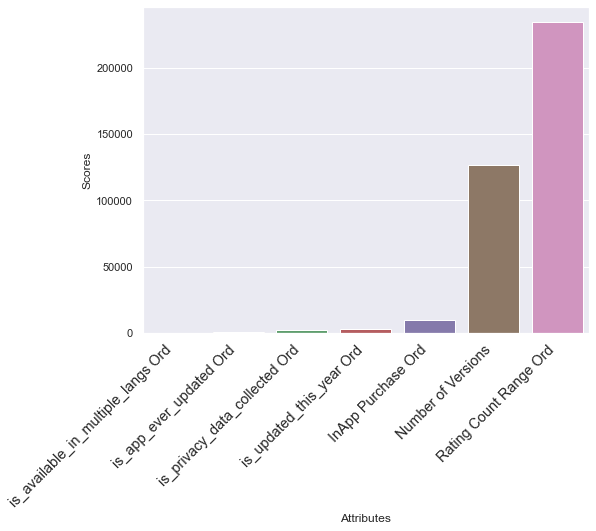

In [92]:
sbn.barplot(x=selected_attributes, y=selected_attributes_score)
set_plot_labels('Attributes', 'Scores', 'large')
fig = pyplot.gcf()
fig.set_size_inches(8, 6)

In [93]:
filtered_attributes = ['Rating Count Range Ord', 'Number of Versions', 'is_privacy_data_collected Ord',
                     'InApp Purchase Ord', 'is_updated_this_year Ord']

In [94]:
updated_df['App Grade Ord'].value_counts()

0    62766
1    36866
3     3016
4     2740
2     2374
Name: App Grade Ord, dtype: int64

In [95]:
X_train, X_test, y_train, y_test = train_test_split(updated_df[filtered_attributes],
                                                    updated_df['App Grade Ord'], test_size=0.25, random_state=42)

In [96]:
y_train.value_counts()

0    47049
1    27657
3     2247
4     2042
2     1826
Name: App Grade Ord, dtype: int64

In [97]:
def oversample_train_data(X_train, y_train):
    oversampler = SMOTE()
    oversampled_df_X, oversampled_df_Y = oversampler.fit_resample(X_train, y_train)
    return oversampled_df_X, oversampled_df_Y

In [98]:
oversampled_df_X, oversampled_df_Y = oversample_train_data(X_train, y_train)

In [99]:
oversampled_df_Y.value_counts()

0    47049
1    47049
3    47049
2    47049
4    47049
Name: App Grade Ord, dtype: int64

In [100]:
def create_and_fit_model(X, Y):
    clf = DecisionTreeClassifier()
    fitted_model = clf.fit(X,Y)
    print('Training score => ', fitted_model.score(X, Y))
    return fitted_model

In [101]:
fitted_model = create_and_fit_model(oversampled_df_X[filtered_attributes], oversampled_df_Y)

Training score =>  0.9291122021722035


In [102]:
def compute_validation_accuracy_and_classification_report(test_X, test_Y):
    y_pred = fitted_model.predict(test_X)
    print('Validation accuracy => ', fitted_model.score(test_X, test_Y))
    target_names = ['BAD','FAIR','GOOD', 'VERY GOOD', 'EXCELLENT']
    print(classification_report(test_Y, y_pred, target_names=target_names))

In [103]:
compute_validation_accuracy_and_classification_report(X_test[filtered_attributes], y_test)

Validation accuracy =>  0.9322222634646078
              precision    recall  f1-score   support

         BAD       1.00      0.90      0.95     15717
        FAIR       0.86      0.99      0.92      9209
        GOOD       0.84      0.84      0.84       548
   VERY GOOD       0.85      0.88      0.86       769
   EXCELLENT       0.86      0.97      0.91       698

    accuracy                           0.93     26941
   macro avg       0.88      0.92      0.90     26941
weighted avg       0.94      0.93      0.93     26941

